# **TECNICATURA UNIVERSITARIA EN INTELIGENCIA ARTIFICIAL**
## TRABAJO PRÁCTICO N° 1: APRENDIZAJE AUTOMÁTICO II
### Rosito, Valentín - (R-4662/1)
### **Fecha Límite de Entrega:** 07/12/2025
### **Semestre:** 2° Semestre 2025

---

## 📑 Tabla de Contenidos

1. [Configuración del Entorno](#1-configuración-del-entorno)
2. [Base Vectorial - ChromaDB](#2-base-vectorial---chromadb)
3. [Base Tabular - Pandas DataFrame](#3-base-tabular---pandas-dataframe)
4. [Base de Datos de Grafos - Memgraph con Neo4j](#4-base-de-datos-de-grafos---memgraph-con-neo4j)
5. [Clasificador de Intención Avanzado](#5-clasificador-de-intención-avanzado)
6. [Pipeline de Recuperación Avanzado](#6-pipeline-de-recuperación-avanzado)
7. [Sistema Conversacional RAG Integrado](#7-sistema-conversacional-rag-integrado)

## 1. Configuración del Entorno

Este notebook implementa un asistente virtual RAG (Retrieval-Augmented Generation) que combina tres tipos de bases de datos:
- **Base Vectorial**: ChromaDB con sentence-transformers para búsquedas semánticas
- **Base Tabular**: Pandas para consultas sobre inventario y precios
- **Base de Grafos**: **Memgraph con Neo4j driver** para relaciones entre productos

### ⚠️ Requisito importante: Memgraph
Para la sección de base de datos de grafos, necesitas tener Memgraph corriendo:

**Opción 1 - Docker (Recomendado)**:
```bash
docker run -p 7687:7687 memgraph/memgraph
```

**Opción 2 - Instalación nativa**:
Descarga desde: https://memgraph.com/download

### 1.1 Instalación de Dependencias


### 1.2 Importación de Librerías

In [1]:
import os
import json
import warnings
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


import chromadb
from chromadb.config import Settings

from neo4j import GraphDatabase

from langchain_core.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI

import matplotlib.pyplot as plt
import seaborn as sns

from rank_bm25 import BM25Okapi
import re
from sentence_transformers import CrossEncoder
from collections import deque
from datetime import datetime
from langdetect import detect, LangDetectException


from collections import deque
from datetime import datetime
warnings.filterwarnings('ignore')

from typing import List, Dict, Any, Optional, Tuple


/Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos/.venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


### 1.3 Configuración de Rutas y Constantes

In [2]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
METADATA_DIR = PROCESSED_DATA_DIR / "metadata"
CHROMA_DB_DIR = PROCESSED_DATA_DIR / "chroma_db"

PRODUCTOS_CSV = RAW_DATA_DIR / "productos.csv"
FAQS_JSON = RAW_DATA_DIR / "faqs.json"
TICKETS_CSV = RAW_DATA_DIR / "tickets_soporte.csv"
MANUALES_DIR = RAW_DATA_DIR / "manuales_productos"
RESENAS_DIR = RAW_DATA_DIR / "resenas_usuarios"

FUNCIONES_CONTEXT = METADATA_DIR / "funciones_disponibles_for_llm.txt"
SCHEMA_CONTEXT = METADATA_DIR / "schema_context_for_llm.txt"

COLLECTION_NAME = "electrodomesticos_docs"

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")



## 2. Base Vectorial - ChromaDB

Esta sección implementa la búsqueda semántica usando ChromaDB. ChromaDB utiliza automáticamente el modelo `all-MiniLM-L6-v2` para generar embeddings, por lo que no necesitamos cargar el modelo manualmente.

**Fuentes de información:**
- Manuales de productos
- FAQs
- Tickets de soporte
- Reseñas de usuarios

### 2.1 Inicialización de ChromaDB

In [3]:
CHROMA_DB_DIR.mkdir(parents=True, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=str(CHROMA_DB_DIR))

print(f"ChromaDB inicializado")

# Crear o obtener colección
try:
    collection = chroma_client.get_collection(name=COLLECTION_NAME)
    print(f"\nColección '{COLLECTION_NAME}' cargada")
    print(f"  Documentos en colección: {collection.count()}")
except:
    collection = chroma_client.create_collection(
        name=COLLECTION_NAME,
        metadata={"description": "Documentación y contenido de electrodomésticos"}
    )
    print(f"\nColección '{COLLECTION_NAME}' creada")

ChromaDB inicializado

Colección 'electrodomesticos_docs' cargada
  Documentos en colección: 10165


### 2.2 Funciones de Carga de Documentos

In [ ]:
def chunk_text(text: str, chunk_size: int = 1000, overlap: int = 50) -> List[str]:
    """
    Divide un texto en chunks con overlap para mejor contexto.
    
    Args:
        text: Texto a dividir
        chunk_size: Tamaño aproximado de cada chunk en caracteres
        overlap: Cantidad de caracteres que se solapan entre chunks
    
    Returns:
        Lista de chunks de texto
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if chunk:
            chunks.append(chunk)
    
    return chunks

def load_manuales() -> List[Dict[str, Any]]:
    """Carga todos los manuales de productos."""
    documentos = []
    
    if not MANUALES_DIR.exists():
        print(f"Directorio de manuales no encontrado: {MANUALES_DIR}")
        return documentos
    
    for manual_file in MANUALES_DIR.glob("*.md"):
        try:
            with open(manual_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = manual_file.stem.split('_')[1] if '_' in manual_file.stem else "unknown"
            
            # Dividir en chunks
            chunks = chunk_text(contenido, chunk_size=500, overlap=50)
            
            for idx, chunk in enumerate(chunks):
                documentos.append({
                    'id': f"manual_{product_id}_chunk_{idx}",
                    'text': chunk,
                    'metadata': {
                        'tipo': 'manual',
                        'producto_id': product_id,
                        'archivo': manual_file.name,
                        'chunk': idx
                    }
                })
        except Exception as e:
            print(f"Error cargando {manual_file.name}: {e}")
    
    return documentos

def load_faqs() -> List[Dict[str, Any]]:
    """Carga las FAQs desde el archivo JSON."""
    documentos = []
    
    if not FAQS_JSON.exists():
        print(f"⚠ Archivo FAQs no encontrado: {FAQS_JSON}")
        return documentos
    
    try:
        with open(FAQS_JSON, 'r', encoding='utf-8') as f:
            faqs = json.load(f)
        
        for idx, faq in enumerate(faqs):
            # Combinar pregunta y respuesta
            texto = f"Pregunta: {faq.get('pregunta', '')}\nRespuesta: {faq.get('respuesta', '')}"
            
            documentos.append({
                'id': f"faq_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'faq',
                    'categoria': faq.get('categoria', 'general')
                }
            })
    except Exception as e:
        print(f"Error cargando FAQs: {e}")
    
    return documentos

def load_tickets() -> List[Dict[str, Any]]:
    """Carga los tickets de soporte."""
    documentos = []
    
    if not TICKETS_CSV.exists():
        print(f"Archivo tickets no encontrado: {TICKETS_CSV}")
        return documentos
    
    try:
        df_tickets = pd.read_csv(TICKETS_CSV)
        
        for idx, row in df_tickets.iterrows():
            # Combinar problema y solución
            texto = f"Problema: {row.get('problema', '')}\nSolución: {row.get('solucion', '')}"
            
            documentos.append({
                'id': f"ticket_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'ticket',
                    'producto_id': row.get('id_producto', 'unknown'),
                    'estado': row.get('estado', 'unknown')
                }
            })
    except Exception as e:
        print(f"Error cargando tickets: {e}")
    
    return documentos

def load_resenas() -> List[Dict[str, Any]]:
    """Carga las reseñas de usuarios."""
    documentos = []
    
    if not RESENAS_DIR.exists():
        print(f" Directorio de reseñas no encontrado: {RESENAS_DIR}")
        return documentos
    
    for resena_file in RESENAS_DIR.glob("*.txt"):
        try:
            with open(resena_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = resena_file.stem.replace('resenas_', '')
            
            documentos.append({
                'id': f"resena_{product_id}",
                'text': contenido,
                'metadata': {
                    'tipo': 'resena',
                    'producto_id': product_id
                }
            })
        except Exception as e:
            print(f"Error cargando {resena_file.name}: {e}")
    
    return documentos

### 2.3 Carga de Documentos en ChromaDB

In [5]:
def populate_vector_db():
    """Carga todos los documentos en ChromaDB."""
    
    # Cargar todos los documentos
    all_docs = []
    
    print("\n1. Cargando manuales...")
    manuales = load_manuales()
    print(f"   {len(manuales)} chunks de manuales cargados")
    all_docs.extend(manuales)
    
    print("\n2. Cargando FAQs...")
    faqs = load_faqs()
    print(f"   {len(faqs)} FAQs cargadas")
    all_docs.extend(faqs)
    
    print("\n3. Cargando tickets de soporte...")
    tickets = load_tickets()
    print(f"   {len(tickets)} tickets cargados")
    all_docs.extend(tickets)
    
    print("\n4. Cargando reseñas...")
    resenas = load_resenas()
    print(f"   {len(resenas)} reseñas cargadas")
    all_docs.extend(resenas)
    
    if not all_docs:
        print("No se encontraron documentos para cargar")
        return
    
    print(f"\nTotal de documentos: {len(all_docs)}")
    
    ids = [doc['id'] for doc in all_docs]
    texts = [doc['text'] for doc in all_docs]
    metadatas = [doc['metadata'] for doc in all_docs]
    
    print("\nInsertando documentos en ChromaDB...")
    
    batch_size = 100
    for i in range(0, len(all_docs), batch_size):
        batch_end = min(i + batch_size, len(all_docs))
        
        collection.add(
            ids=ids[i:batch_end],
            documents=texts[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )
        
        print(f"Procesados {batch_end}/{len(all_docs)} documentos")
        
    print(f"\nBase vectorial poblada exitosamente")
    print(f"Total documentos en colección: {collection.count()}")


if collection.count() == 0:
    populate_vector_db()
else:
    print(f"ase vectorial ya contiene {collection.count()} documentos")
    print("Para recargar, elimina la colección primero")

ase vectorial ya contiene 10165 documentos
Para recargar, elimina la colección primero


### 2.4 Función de Búsqueda Semántica

In [6]:
def semantic_search(query: str, n_results: int = 5, filter_tipo: Optional[str] = None) -> Dict[str, Any]:
    """
    Realiza búsqueda semántica en la base vectorial.
    ChromaDB genera automáticamente el embedding de la query usando all-MiniLM-L6-v2.
    
    Args:
        query: Consulta del usuario
        n_results: Número de resultados a retornar
        filter_tipo: Filtrar por tipo de documento ('manual', 'faq', 'ticket', 'resena')
    
    Returns:
        Dict con resultados de la búsqueda
    """
    # Preparar filtro si es necesario
    where_clause = {"tipo": filter_tipo} if filter_tipo else None
    
    # ChromaDB genera automáticamente el embedding de la query
    results = collection.query(
        query_texts=[query],
        n_results=n_results,
        where=where_clause
    )
    
    # Formatear resultados
    formatted_results = {
        'query': query,
        'n_results': len(results['ids'][0]),
        'documents': []
    }
    
    for i in range(len(results['ids'][0])):
        formatted_results['documents'].append({
            'id': results['ids'][0][i],
            'text': results['documents'][0][i],
            'metadata': results['metadatas'][0][i],
            'distance': results['distances'][0][i] if 'distances' in results else None
        })
    
    return formatted_results

## 3. Base Tabular - Pandas DataFrame

Esta sección implementa consultas estructuradas sobre el inventario de productos:
- Filtrado por precio, stock, categoría
- Comparación de productos
- Análisis de disponibilidad

### 3.1 Carga del DataFrame de Productos

In [7]:
df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"{len(df_productos)} productos cargados")
print(f"\nColumnas disponibles:")
for col in df_productos.columns:
    print(f"  - {col}")

print(f"\nEjemplo de productos:")
df_productos.head(3)

300 productos cargados

Columnas disponibles:
  - id_producto
  - nombre
  - categoria
  - subcategoria
  - marca
  - precio_usd
  - stock
  - color
  - potencia_w
  - capacidad
  - voltaje
  - peso_kg
  - garantia_meses
  - descripcion

Ejemplo de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,220V,35.9,36,"Descubrí el poder de la Licuadora de TechHome,..."
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...


### 3.2 Análisis Exploratorio del DataFrame

INFORMACIÓN DEL DATASET
Total de productos: 300
Categorías: 4
Marcas: 17


DISTRIBUCIÓN POR CATEGORÍA
categoria
Cocina           147
Climatización     81
Lavado            70
Audio y Video      2
Name: count, dtype: int64


ESTADÍSTICAS DE PRECIOS (USD)
count     300.000000
mean     1481.669567
std       845.525639
min        28.220000
25%       836.260000
50%      1409.915000
75%      2142.560000
max      2992.330000
Name: precio_usd, dtype: float64


ESTADÍSTICAS DE STOCK
count    300.000000
mean      99.950000
std       58.354534
min        1.000000
25%       48.250000
50%      100.000000
75%      150.000000
max      200.000000
Name: stock, dtype: float64


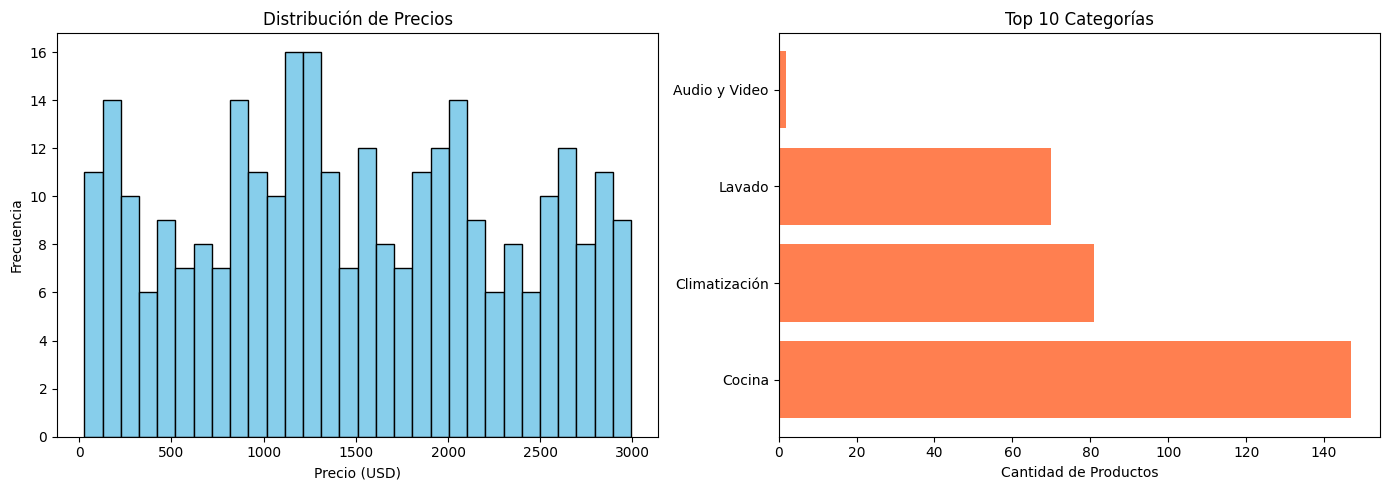

In [8]:
# Información del DataFrame
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Total de productos: {len(df_productos)}")
print(f"Categorías: {df_productos['categoria'].nunique()}")
print(f"Marcas: {df_productos['marca'].nunique()}")

print("\n\nDISTRIBUCIÓN POR CATEGORÍA")
print("=" * 60)
print(df_productos['categoria'].value_counts())

print("\n\nESTADÍSTICAS DE PRECIOS (USD)")
print("=" * 60)
print(df_productos['precio_usd'].describe())

print("\n\nESTADÍSTICAS DE STOCK")
print("=" * 60)
print(df_productos['stock'].describe())

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de precios
axes[0].hist(df_productos['precio_usd'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Precios')
axes[0].set_xlabel('Precio (USD)')
axes[0].set_ylabel('Frecuencia')

# Top 10 categorías
top_categorias = df_productos['categoria'].value_counts().head(10)
axes[1].barh(range(len(top_categorias)), top_categorias.values, color='coral')
axes[1].set_yticks(range(len(top_categorias)))
axes[1].set_yticklabels(top_categorias.index)
axes[1].set_title('Top 10 Categorías')
axes[1].set_xlabel('Cantidad de Productos')

plt.tight_layout()
plt.show()

In [9]:
df_productos.groupby('categoria')['precio_usd'].mean().sort_values(ascending=False)

categoria
Climatización    1599.313704
Lavado           1509.291429
Cocina           1412.248776
Audio y Video     852.745000
Name: precio_usd, dtype: float64

### 3.2.1 Análisis de Variables Categóricas y Continuas
----
> Variables como `capacidad` y `voltaje` son strings conformadas en este formato (30L, 220V) respectivamente. O algunos casos en `voltaje` donde algun registro está en el formato: "110-220V".

In [10]:
resumen = {
    'CATEGÓRICAS': {},
    'CONTINUAS': {}
}

for var in ['categoria', 'subcategoria', 'marca', 'color', 'voltaje', 'capacidad']:
    if var in df_productos.columns:
        valores = sorted([str(v) for v in df_productos[var].unique() if pd.notna(v)])
        resumen['CATEGÓRICAS'][var] = valores

for var in ['precio_usd', 'stock', 'potencia_w', 'peso_kg', 'garantia_meses']:
    if var in df_productos.columns:
        valores = df_productos[var].dropna()
        if len(valores) > 0:
            resumen['CONTINUAS'][var] = {
                'min': valores.min(),
                'mediana': valores.median(),
                'max': valores.max()
            }

print("\n📊 VARIABLES CATEGÓRICAS:")
print("─" * 80)
for var, valores in resumen['CATEGÓRICAS'].items():
    print(f"\n{var}: ({len(valores)} valores únicos)")
    print(f"  {', '.join(valores[:10])}")
    if len(valores) > 10:
        print(f"  ... y {len(valores) - 10} más")

print("\n\n📈 VARIABLES CONTINUAS:")
print("─" * 80)
for var, stats in resumen['CONTINUAS'].items():
    print(f"\n{var}:")
    print(f"  Mínimo: {stats['min']:,.2f} | Mediana: {stats['mediana']:,.2f} | Máximo: {stats['max']:,.2f}")


📊 VARIABLES CATEGÓRICAS:
────────────────────────────────────────────────────────────────────────────────

categoria: (4 valores únicos)
  Audio y Video, Climatización, Cocina, Lavado

subcategoria: (13 valores únicos)
  Aires Acondicionados, Calefacción, Cocción, Lavado de Ropa, Lavado de Vajilla, Pequeños Electrodomésticos, Planchado, Preparación, Purificación, Refrigeración
  ... y 3 más

marca: (17 valores únicos)
  AirFlow, ChefMaster, CleanMaster, ClimaTech, CookElite, EcoClima, FreshWash, HomeChef, KitchenPro, LaundryTech
  ... y 7 más

color: (10 valores únicos)
  Amarillo, Azul, Blanco, Dorado, Gris, Negro, Plateado, Rojo, Rosa, Verde

voltaje: (3 valores únicos)
  110-220V, 12V, 220V

capacidad: (20 valores únicos)
  1.0L, 1.2L, 1.5L, 1.8L, 10kg, 12kg, 2.0L, 2.5L, 200L, 3.0L
  ... y 10 más


📈 VARIABLES CONTINUAS:
────────────────────────────────────────────────────────────────────────────────

precio_usd:
  Mínimo: 28.22 | Mediana: 1,409.91 | Máximo: 2,992.33

stock:
  Míni

### 3.2.2 Contexto y almacenamiento para LLM

> En este caso, almacené en un .txt la siguiente información sobre la **base de datos tabular**:

    - nombre_dataset: nombre del dataset (string).
    - total_registros: cantidad total de filas en df_productos (int).
    - columnas: lista con los nombres de las columnas del DataFrame (lista de strings).
    - descripcion_general: descripción textual del dataset.


**variables_categoricas**: objeto donde cada variable categórica (ej. categoria, subcategoria, marca, color, voltaje, capacidad) tiene:

    - tipo: "categorical"
    - valores_unicos: lista ordenada de valores únicos (strings)
    - cantidad_valores: número de valores únicos (int)

**variables_continuas**: objeto donde cada variable numérica (ej. precio_usd, stock, potencia_w, peso_kg, garantia_meses) tiene:

    - tipo: "numeric"
    - minimo: valor mínimo (float)
    - maximo: valor máximo (float)
    - mediana: mediana (float)

> Decidí mantener este contexto **(≈700 tokens)** porque, comparado con la **ventana de contexto de Gemini 2.0 Flash (≈1,000,000 tokens)**, es insignificante y útil para el LLM.

---


## **Estrategia de Consulta con LLM:**

El LLM recibirá dos contextos:
1. **Schema del dataset** (`schema_context_for_llm.txt`): Información sobre variables categóricas y numéricas (Convertido del JSON creado previamente)
2. **Funciones disponibles** (`funciones_disponibles_for_llm.txt`): Especificación de las 8 funciones disponibles con ejemplos de JSON

El LLM analizará la consulta del usuario y retornará un JSON con:
- `funcion`: nombre de la función a ejecutar
- `parametros`: diccionario con los parámetros a pasar

Este enfoque permite que el LLM actúe como un **router inteligente** que traduce lenguaje natural a llamadas de función estructuradas.

In [11]:
def get_schema_metadata_for_llm() -> str:
    """
    Retorna los metadatos del schema en formato texto optimizado para LLM.
    Este contexto será usado por el LLM para elegir qué función llamar.
    
    Returns:
        String con la descripción completa del schema para contexto del LLM
    """
    with open(SCHEMA_CONTEXT, 'r', encoding='utf-8') as f:
      schema_text = f.read()

    return schema_text


def get_funciones_disponibles_for_llm() -> str:
    """
    Retorna la documentación de las funciones disponibles para que el LLM 
    pueda elegir cuál usar y con qué parámetros.
    
    Returns:
        String con la especificación de las funciones disponibles
    """
    with open(FUNCIONES_CONTEXT, 'r', encoding='utf-8') as f:
      funciones_spec = f.read()
    
    return funciones_spec

In [12]:
llm_schema_context = get_schema_metadata_for_llm()
llm_funciones_context = get_funciones_disponibles_for_llm()

print(f"\nArchivo 1: Schema del Dataset")
print(f"  Tamaño: {len(llm_schema_context)} caracteres (~{len(llm_schema_context)//3} tokens)")

print(f"\nArchivo 2: Funciones Disponibles")
print(f"  Tamaño: {len(llm_funciones_context)} caracteres (~{len(llm_funciones_context)//3} tokens)")


Archivo 1: Schema del Dataset
  Tamaño: 1942 caracteres (~647 tokens)

Archivo 2: Funciones Disponibles
  Tamaño: 4396 caracteres (~1465 tokens)


### 3.3 Funciones de Consulta Tabular

In [ ]:
def buscar_por_precio(precio_min: float = None, precio_max: float = None, 
                      categoria: str = None, subcategoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Busca productos por rango de precio y opcionalmente por categoría, subcategoría y marca.
    
    Args:
        precio_min: Precio mínimo
        precio_max: Precio máximo
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
        marca: Marca del producto
    
    Returns:
        DataFrame con productos filtrados
    """
    df = df_productos.copy()
    
    if precio_min is not None:
        df = df[df['precio_usd'] >= precio_min]
    
    if precio_max is not None:
        df = df[df['precio_usd'] <= precio_max]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.sort_values('precio_usd')

def buscar_por_stock(stock_min: int = 0, categoria: str = None, subcategoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Busca productos con stock disponible.
    
    Args:
        stock_min: Stock mínimo requerido
        categoria: Categoría de producto
        subcategoria: Subcategoría de producto
        marca: Marca del producto
    
    Returns:
        DataFrame con productos con stock
    """
    df = df_productos[df_productos['stock'] >= stock_min]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.sort_values('stock', ascending=False)

def buscar_por_caracteristicas(marca: str = None, categoria: str = None, 
                               subcategoria: str = None, color: str = None) -> pd.DataFrame:
    """
    Busca productos por características específicas.
    
    Args:
        marca: Marca del producto
        categoria: Categoría
        subcategoria: Subcategoría
        color: Color del producto
    
    Returns:
        DataFrame con productos que cumplen los criterios
    """
    df = df_productos.copy()
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if color is not None:
        df = df[df['color'].str.contains(color, case=False, na=False)]
    
    return df

def comparar_productos(ids_productos: List[str]) -> pd.DataFrame:
    """
    Compara múltiples productos lado a lado.
    
    Args:
        ids_productos: Lista de IDs de productos a comparar
    
    Returns:
        DataFrame con comparación de productos
    """
    df = df_productos[df_productos['id_producto'].isin(ids_productos)]
    
    columnas_importantes = ['id_producto', 'nombre', 'marca', 'precio_usd', 
                           'stock', 'potencia_w', 'capacidad', 'garantia_meses']
    
    # Seleccionar solo columnas que existen
    columnas_existentes = [col for col in columnas_importantes if col in df.columns]
    
    return df[columnas_existentes].T

def productos_mas_baratos(n: int = 10, categoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más baratos.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
        marca: Filtrar por marca (opcional)
    
    Returns:
        DataFrame con los productos más baratos
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.nsmallest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def productos_mas_caros(n: int = 10, categoria: str = None, marca: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más caros.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
        marca: Filtrar por marca (opcional)
    
    Returns:
        DataFrame con los productos más caros
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    return df.nlargest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]


def buscar_por_id(id_producto: str) -> Optional[Dict[str, Any]]:
    """
    Busca un producto por su ID.
    
    Args:
        id_producto: ID del producto a buscar
    
    Returns:
        Diccionario con información del producto o None si no se encuentra
    """
    producto = df_productos[df_productos['id_producto'] == id_producto]
    
    if producto.empty:
        return None
    
    return producto.iloc[0].to_dict()

def obtener_categorias() -> List[str]:
    """Retorna lista de todas las categorías disponibles."""
    return sorted(df_productos['categoria'].unique().tolist())

def obtener_marcas() -> List[str]:
    """Retorna lista de todas las marcas disponibles."""
    return sorted(df_productos['marca'].unique().tolist())

### 3.4 Interfaz para Consultas con LLM

Esta interfaz permite que un LLM interprete consultas en lenguaje natural y las traduzca a llamadas de función estructuradas.

In [14]:
# Prompt para consulta con funciones

def crear_prompt_llm_template(schema_context: str = llm_schema_context,
                                funciones_context: str = llm_funciones_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde sólo `consulta_usuario` será variable
    al invocarlo.

    Usa las variables `llm_schema_context` y `llm_funciones_context` definidas
    en el notebook para fijar el contexto del prompt.
    """
    # Escapar llaves para que LangChain no las interprete como variables
    schema_escaped = schema_context.replace("{", "{{").replace("}", "}}")
    funciones_escaped = funciones_context.replace("{", "{{").replace("}", "}}")
    
    template = f"""{schema_escaped}

---

{funciones_escaped}

---

## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## TU RESPUESTA (SOLO JSON):
"""
    return PromptTemplate(input_variables=["consulta_usuario"], template=template)


# Prompt para descripción de resultados

def crear_prompt_llm_desc(schema_context: str = llm_schema_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde `consulta_usuario` e `informacion_recuperada`
    serán variables al invocarlo.

    Usa la variable `llm_schema_context` definida en el notebook para fijar el contexto del prompt.
    """
    # Escapar llaves para que LangChain no las interprete como variables
    schema_escaped = schema_context.replace("{", "{{").replace("}", "}}")
    
    template = f"""
# EN BASE A ESTE CONTEXTO DEL DATASET, LA PREGUNTA DEL USUARIO Y ESTA INFORMACION RECUPERADA DE UNA BASE DE DATOS TABULAR:

{schema_escaped}
---
## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## INFORMACION RECUPERADA DE LA BASE DE DATOS TABULAR:
{{informacion_recuperada}}


## DESCRIBE BREVE Y CONCISAMENTE LOS RESULTADOS OBTENIDOS:

## TU RESPUESTA (UNA DESCRIPCION BREVE):
"""
    return PromptTemplate(input_variables=["consulta_usuario", "informacion_recuperada"], template=template)


# Invocación de LLMs

def invocar_llm_desc(llm, consulta_usuario: str, informacion_recuperada: str) -> str:
    """
    Helper que crea una descripcion breve de los resultados obtenidos.
    Retorna el texto devuelto por el LLM.
    """
    prompt = crear_prompt_llm_desc()
    chain = prompt | llm
    return chain.invoke({
        "consulta_usuario": consulta_usuario,
        "informacion_recuperada": informacion_recuperada
    })

def invocar_llm_con_consulta(llm, consulta_usuario: str) -> str:
    """
    Helper que crea el chain y ejecuta la consulta.
    Retorna el texto devuelto por el LLM (puede ser JSON en texto).
    """
    prompt = crear_prompt_llm_template()
    chain = prompt | llm
    return chain.invoke({"consulta_usuario": consulta_usuario})


#### Funciones para consultar el Dataframe
---

In [15]:
FUNCIONES_DISPONIBLES = {
    'buscar_por_precio': buscar_por_precio,
    'buscar_por_stock': buscar_por_stock,
    'buscar_por_caracteristicas': buscar_por_caracteristicas,
    'comparar_productos': comparar_productos,
    'productos_mas_baratos': productos_mas_baratos,
    'productos_mas_caros': productos_mas_caros,
    'obtener_categorias': obtener_categorias,
    'buscar_por_id': buscar_por_id,
    'obtener_marcas': obtener_marcas
}

def ejecutar_consulta_tabular(funcion_json: Dict[str, Any]) -> Any:
    """
    Ejecuta una consulta tabular basada en el JSON retornado por el LLM.

    Returns:
        Resultado de la función (generalmente un DataFrame)
    
    Raises:
        ValueError: Si la función no existe o hay errores en los parámetros
    """
    # Validar estructura del JSON
    if not isinstance(funcion_json, dict):
        raise ValueError("El input debe ser un diccionario")
    
    if 'funcion' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'funcion'")
    
    if 'parametros' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'parametros'")
    
    nombre_funcion = funcion_json['funcion']
    parametros = funcion_json['parametros']
    
    # Validar que la función existe
    if nombre_funcion not in FUNCIONES_DISPONIBLES:
        funciones_validas = ', '.join(FUNCIONES_DISPONIBLES.keys())
        raise ValueError(
            f"Función '{nombre_funcion}' no encontrada. "
            f"Funciones disponibles: {funciones_validas}"
        )
    
    funcion = FUNCIONES_DISPONIBLES[nombre_funcion]
    
    try:
        resultado = funcion(**parametros)
        return resultado
    except TypeError as e:
        raise ValueError(f"Error en los parámetros de '{nombre_funcion}': {str(e)}")
    except Exception as e:
        raise ValueError(f"Error ejecutando '{nombre_funcion}': {str(e)}")


def consulta_con_llm_tabular(llm, 
    consulta_usuario: str) -> Any:
    """
    Interfaz principal para realizar consultas en lenguaje natural sobre la base tabular.
    
    Esta función:
    1. Prepara el contexto (schema + funciones disponibles) para el LLM
    2. Envía la consulta del usuario al LLM
    3. El LLM retorna un JSON con la función y parámetros
    4. Ejecuta la función correspondiente
    5. Retorna el resultado

    Devuelve:
        Resultado de la consulta (generalmente un DataFrame)
    """
    
    # 2. Llamar al LLM
    try:
        respuesta_llm = invocar_llm_con_consulta(llm, consulta_usuario)
        # 3. Parsear JSON
        # El LLM puede retornar JSON en markdown (```json ... ```)
        respuesta_limpia = respuesta_llm.strip()
        
        # Limpiar markdown code blocks si existen
        if respuesta_limpia.startswith("```"):
            # Encontrar el contenido entre ``` y ```
            lineas = respuesta_limpia.split('\n')
            respuesta_limpia = '\n'.join(lineas[1:-1])
        
        funcion_json = json.loads(respuesta_limpia)

        # 4. Ejecutar la función
        resultado = ejecutar_consulta_tabular(funcion_json)

        desc = invocar_llm_desc(llm, consulta_usuario, str(resultado))

        return desc, resultado
        
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON del LLM: {str(e)}\nRespuesta: {respuesta_llm}")
    except Exception as e:
        raise ValueError(f"Error en la consulta: {str(e)}")
    
def consulta_con_llm_tabular_no_desc(llm, 
    consulta_usuario: str) -> Any:
    """
    Interfaz principal para realizar consultas en lenguaje natural sobre la base tabular.
    
    Esta función:
    1. Prepara el contexto (schema + funciones disponibles) para el LLM
    2. Envía la consulta del usuario al LLM
    3. El LLM retorna un JSON con la función y parámetros
    4. Ejecuta la función correspondiente
    5. Retorna el resultado

    Devuelve:
        Resultado de la consulta (generalmente un DataFrame)
    """
    
    # 2. Llamar al LLM
    try:
        respuesta_llm = invocar_llm_con_consulta(llm, consulta_usuario)
        # 3. Parsear JSON
        # El LLM puede retornar JSON en markdown (```json ... ```)
        respuesta_limpia = respuesta_llm.strip()
        
        # Limpiar markdown code blocks si existen
        if respuesta_limpia.startswith("```"):
            # Encontrar el contenido entre ``` y ```
            lineas = respuesta_limpia.split('\n')
            respuesta_limpia = '\n'.join(lineas[1:-1])
        
        funcion_json = json.loads(respuesta_limpia)

        # 4. Ejecutar la función
        resultado = ejecutar_consulta_tabular(funcion_json)

        return resultado
        
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON del LLM: {str(e)}\nRespuesta: {respuesta_llm}")
    except Exception as e:
        raise ValueError(f"Error en la consulta: {str(e)}")

### Integracion y pruebas Google Gemini

A continuación se muestran ejemplos de uso de la interfaz

In [16]:
llm = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=api_key)

> Elegi este modelo, ya que estoy usando la API gratuita de Google y este permite 15 consultas por minuto. Además de ofrecer una alta precision y poser una amplia ventana de contexto de 1M de tokens.

In [17]:
print("=" * 80)
print("PRUEBA 1: Productos más baratos")
print("=" * 80)

resultado1, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Muéstrame los 5 productos más económicos",
)

print("\n📊 Resultados:")
print(resultado1)
display(data)

PRUEBA 1: Productos más baratos

📊 Resultados:
Los 5 productos más económicos son: un lavavajillas WashPro, un molinillo de café HomeChef, un lavarropas CleanMaster, una pava eléctrica HomeChef y un mixer ChefMaster. Los precios varían entre $28.22 y $52.70 USD.

📊 Resultados:
Los 5 productos más económicos son: un lavavajillas WashPro, un molinillo de café HomeChef, un lavarropas CleanMaster, una pava eléctrica HomeChef y un mixer ChefMaster. Los precios varían entre $28.22 y $52.70 USD.


,id_producto,nombre,marca,precio_usd,stock
273,P0274,Lavavajillas,WashPro,28.22,122
38,P0039,Premium Molinillo de Café,HomeChef,30.02,137
235,P0236,Lavarropas Semiautomático X,CleanMaster,40.45,78
123,P0124,Pava Eléctrica 2024,HomeChef,47.86,77
26,P0027,Mixer Pro,ChefMaster,52.70,159


In [18]:
print("=" * 80)
print("PRUEBA 2: Productos con stock disponible")
print("=" * 80)

resultado2, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="¿Qué productos tienen stock disponible?",
)

print(f"\n📊 Resultados:")
print(resultado2)
display(data)

PRUEBA 2: Productos con stock disponible

📊 Resultados:
La información recuperada muestra una lista de 300 productos de electrodomésticos con stock disponible, incluyendo detalles como nombre, categoría, subcategoría, marca, precio, stock, color y especificaciones técnicas.

📊 Resultados:
La información recuperada muestra una lista de 300 productos de electrodomésticos con stock disponible, incluyendo detalles como nombre, categoría, subcategoría, marca, precio, stock, color y especificaciones técnicas.


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
21,P0022,Advanced Batidora de Pie,Cocina,Preparación,KitchenPro,2781.38,200,Gris,1400.0,NaN,220V,49.3,18,Presentamos la Advanced Batidora de Pie de Kit...
285,P0286,Plancha Seca,Lavado,Planchado,WashPro,1580.93,200,Azul,200.0,NaN,220V,25.1,18,"Presentamos la Plancha Seca de WashPro, un pro..."
128,P0129,Exprimidor 2024,Cocina,Pequeños Electrodomésticos,ChefMaster,601.85,198,Verde,1800.0,NaN,12V,6.1,36,"Presentamos la Exprimidor 2024 de ChefMaster, ..."
291,P0292,Centro de Planchado,Lavado,Planchado,CleanMaster,2601.44,198,Azul,300.0,NaN,110-220V,3.9,24,Presentamos la Centro de Planchado de CleanMas...
268,P0269,Tender Eléctrico 3000,Lavado,Secado,WashPro,1756.31,198,Negro,1350.0,NaN,110-220V,47.5,18,Presentamos la Tender Eléctrico 3000 de WashPr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,P0229,Deluxe Lavarropas Automático 2024,Lavado,Lavado de Ropa,WashPro,191.93,2,Plateado,300.0,8kg,110-220V,19.2,24,Presentamos la Deluxe Lavarropas Automático 20...
93,P0094,Elite Heladera,Cocina,Refrigeración,CookElite,784.59,2,Gris,650.0,350L,110-220V,32.1,24,"Presentamos la Elite Heladera de CookElite, un..."
194,P0195,Ventilador de Torre 2024,Climatización,Ventilación,AirFlow,2633.30,2,Azul,90.0,NaN,110-220V,9.7,18,Presentamos la Ventilador de Torre 2024 de Air...
177,P0178,Panel Calefactor,Climatización,Calefacción,AirFlow,875.09,2,Negro,350.0,NaN,110-220V,25.0,24,"Presentamos la Panel Calefactor de AirFlow, un..."


In [19]:
print("=" * 80)
print("PRUEBA 3: Buscar refrigeradores por rango de precio")
print("=" * 80)

resultado3, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Dame de la subcategoria refrigeradores entre $400 y $700",
)

print(f"\n📊 Resultados:")
print(resultado3)
display(data.head(10))

PRUEBA 3: Buscar refrigeradores por rango de precio

📊 Resultados:
Se encontraron tres refrigeradores de las marcas ChefMaster y KitchenPro con precios entre $400 y $700. Sus características varían en color, potencia, capacidad, voltaje, peso y garantía.

📊 Resultados:
Se encontraron tres refrigeradores de las marcas ChefMaster y KitchenPro con precios entre $400 y $700. Sus características varían en color, potencia, capacidad, voltaje, peso y garantía.


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
92,P0093,Heladera,Cocina,Refrigeración,ChefMaster,530.69,20,Rosa,1850.0,500L,12V,34.2,12,"Presentamos la Heladera de ChefMaster, un prod..."
106,P0107,Smart Conservadora 2024,Cocina,Refrigeración,KitchenPro,635.48,195,Dorado,1250.0,NaN,220V,49.4,36,Presentamos la Smart Conservadora 2024 de Kitc...
117,P0118,Pro Vinoteca,Cocina,Refrigeración,ChefMaster,692.12,27,Verde,1800.0,NaN,220V,8.2,24,"Presentamos la Pro Vinoteca de ChefMaster, un ..."


In [20]:
print("=" * 80)
print("PRUEBA 4: Productos de marca KitchenPro")
print("=" * 80)

resultado4, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Muéstrame todos los productos KitchenPro disponibles",
)

print(f"\n📊 Resultados:")
print(resultado4)
display(data.head(10))

PRUEBA 4: Productos de marca KitchenPro

📊 Resultados:
Se muestran 28 productos de la marca KitchenPro, incluyendo licuadoras, procesadoras, picadoras, batidoras, mixers, abridores de latas, microondas, freidoras de aire, tostadoras, sandwicheras, wafleras, parrillas eléctricas, ollas de cocción lenta, conservadoras, pavas eléctricas, exprimidores, yogurteras y deshidratadores. Se proporciona información detallada sobre cada producto, incluyendo categoría, subcategoría, precio, stock, color, potencia, capacidad, voltaje, peso, garantía y descripción.

📊 Resultados:
Se muestran 28 productos de la marca KitchenPro, incluyendo licuadoras, procesadoras, picadoras, batidoras, mixers, abridores de latas, microondas, freidoras de aire, tostadoras, sandwicheras, wafleras, parrillas eléctricas, ollas de cocción lenta, conservadoras, pavas eléctricas, exprimidores, yogurteras y deshidratadores. Se proporciona información detallada sobre cada producto, incluyendo categoría, subcategoría, precio, 

,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
6,P0007,Licuadora,Cocina,Preparación,KitchenPro,2532.47,198,Blanco,1300.0,2.5L,12V,11.4,18,Descubrí el poder de la Licuadora de KitchenPr...
8,P0009,Procesadora,Cocina,Preparación,KitchenPro,1213.21,56,Plateado,900.0,2.5L,12V,21.7,36,La Procesadora de KitchenPro es tu aliada perf...
12,P0013,Procesadora,Cocina,Preparación,KitchenPro,82.93,92,Azul,1700.0,2.0L,220V,30.1,24,La Procesadora de KitchenPro es tu aliada perf...
13,P0014,Premium Picadora,Cocina,Preparación,KitchenPro,2303.35,32,Gris,1750.0,NaN,220V,48.9,36,"Presentamos la Premium Picadora de KitchenPro,..."
19,P0020,Batidora de Pie,Cocina,Preparación,KitchenPro,768.16,19,Gris,600.0,NaN,110-220V,9.6,24,"Presentamos la Batidora de Pie de KitchenPro, ..."
21,P0022,Advanced Batidora de Pie,Cocina,Preparación,KitchenPro,2781.38,200,Gris,1400.0,NaN,220V,49.3,18,Presentamos la Advanced Batidora de Pie de Kit...
24,P0025,Mixer,Cocina,Preparación,KitchenPro,757.48,152,Blanco,950.0,NaN,110-220V,6.4,36,"Presentamos la Mixer de KitchenPro, un product..."
33,P0034,Turbo Abridor de Latas,Cocina,Preparación,KitchenPro,2779.14,60,Plateado,1950.0,NaN,110-220V,48.7,12,Presentamos la Turbo Abridor de Latas de Kitch...
34,P0035,Profesional Abridor de Latas,Cocina,Preparación,KitchenPro,818.74,179,Negro,1250.0,NaN,110-220V,40.2,12,Presentamos la Profesional Abridor de Latas de...
46,P0047,Turbo Microondas,Cocina,Cocción,KitchenPro,1847.63,184,Dorado,1100.0,NaN,12V,16.2,24,"Presentamos la Turbo Microondas de KitchenPro,..."


In [21]:
print("=" * 80)
print("PRUEBA 5: Comparar productos específicos")
print("=" * 80)

resultado5, data = consulta_con_llm_tabular(llm=llm,
    consulta_usuario="Compara los productos P0001, P0002 y P0003",
)

print(f"\n📊 Resultados:")
print(resultado5)
display(data)

PRUEBA 5: Comparar productos específicos

📊 Resultados:
Se comparan tres licuadoras de la marca TechHome. P0001 y P0003 tienen una capacidad de 1.2L, mientras que P0002 tiene 2.0L. El precio varía significativamente, siendo P0002 el más caro (1273.06 USD) y P0001 el más barato (283.63 USD). La potencia es similar entre P0001 (650W) y P0003 (700W), mientras que P0002 tiene menor potencia (300W). P0001 y P0002 tienen una garantía de 36 meses, mientras que P0003 ofrece solo 18 meses. El stock es similar en los tres productos.

📊 Resultados:
Se comparan tres licuadoras de la marca TechHome. P0001 y P0003 tienen una capacidad de 1.2L, mientras que P0002 tiene 2.0L. El precio varía significativamente, siendo P0002 el más caro (1273.06 USD) y P0001 el más barato (283.63 USD). La potencia es similar entre P0001 (650W) y P0003 (700W), mientras que P0002 tiene menor potencia (300W). P0001 y P0002 tienen una garantía de 36 meses, mientras que P0003 ofrece solo 18 meses. El stock es similar en los

,0,1,2
id_producto,P0001,P0002,P0003
nombre,Licuadora,Licuadora,Plus Licuadora Pro
marca,TechHome,TechHome,TechHome
precio_usd,283.63,1273.06,329.07
stock,108,114,97
potencia_w,650.0,300.0,700.0
capacidad,1.2L,2.0L,1.2L
garantia_meses,36,36,18


### **Arquitectura de la Interfaz**

Usuario escribe la consulta

    ↓
`consulta_con_llm_tabular()` prepara contexto

    ↓
LLM analiza y devuelve JSON con función + parámetros

    ↓
`ejecutar_consulta_tabular()` valida y ejecuta

    ↓
Retorna DataFrame con resultados

    ↓
Se genera una descripción.

---

#### **Ventajas de esta Arquitectura**

1. **Separación de Responsabilidades**: El LLM solo interpreta, no ejecuta código
2. **Seguridad**: Solo se pueden ejecutar funciones predefinidas
3. **Flexibilidad**: Fácil agregar nuevas funciones al diccionario
4. **Testing**: Se puede probar sin llamar al LLM (usando `llm_simulado`)
5. **Multi-LLM**: Compatible con cualquier LLM (Gemini, GPT-4, Claude, etc.)

---

#### **Cómo Agregar Nuevas Funciones**

```python
# 1. Define la función
def mi_nueva_funcion(...)

# 2. Agrégala al diccionario
FUNCIONES_DISPONIBLES['mi_nueva_funcion'] = mi_nueva_funcion

# 3. Documéntala en get_funciones_disponibles_for_llm()
```

#### **Contexto Enviado al LLM**

El LLM recibe:
- **Schema del dataset**: Variables categóricas y numéricas con sus valores posibles
- **Funciones disponibles**: 8 funciones documentadas con ejemplos de JSON
- **Consulta del usuario**: Texto en lenguaje natural

Total: ~3,000 tokens (0.3% de la ventana de Gemini 2.0 Flash)

---

## 4. Base de Datos de Grafos - Memgraph con Neo4j

Esta sección implementa una base de datos de grafos usando **Memgraph** accesible mediante el driver de Neo4j:
- **Nodos**: Productos con todas sus propiedades
- **Relaciones**: MISMA_CATEGORIA, MISMA_SUBCATEGORIA, MISMA_MARCA, SIMILAR_PRECIO, MISMO_VOLTAJE
- **Consultas Cypher**: Convertidas desde lenguaje natural usando LLM
- **Interface única**: Función que recibe consulta NL y devuelve resultados del grafo
- **Base de datos**: Memgraph corriendo en `bolt://localhost:7687`

### 4.1. Configuración de Memgraph con Neo4j Driver

La implementación usa el driver oficial de Neo4j para conectarse a Memgraph:
- Conexión a `bolt://localhost:7687`
- Soporte completo para consultas Cypher
- Gestión de transacciones y sesiones
- Base de datos: `memgraph`

In [22]:
# Configuración de conexión a Memgraph
URI = "bolt://localhost:7687"
AUTH = ("", "")  # Sin autenticación por defecto en Memgraph

class MemgraphConnection:
    """
    Clase para manejar la conexión y operaciones con Memgraph usando el driver de Neo4j.
    Compatible con la sintaxis completa de Cypher.
    """
    
    def __init__(self, uri: str = URI, auth: tuple = AUTH):
        """
        Inicializa la conexión con Memgraph
        
        Args:
            uri: URI de conexión (bolt://localhost:7687)
            auth: Tupla con (usuario, password)
        """
        self.uri = uri
        self.auth = auth
        self.driver = None
        self._connect()
    
    def _connect(self):
        """Establece conexión con Memgraph"""
        try:
            self.driver = GraphDatabase.driver(self.uri, auth=self.auth)
            self.driver.verify_connectivity()
            print(f"✓ Conectado a Memgraph en {self.uri}")
        except Exception as e:
            print(f"✗ Error conectando a Memgraph: {e}")
            print("\nAsegúrate de que Memgraph esté corriendo:")
            print("  Docker: docker run -p 7687:7687 memgraph/memgraph")
            print("  O sigue las instrucciones en: https://memgraph.com/docs/getting-started")
            raise
    
    def close(self):
        """Cierra la conexión"""
        if self.driver:
            self.driver.close()
            print("Conexión cerrada")
    
    def execute_query(self, query: str, parameters: Dict = None) -> List[Dict]:
        """
        Ejecuta una query Cypher y devuelve los resultados
        
        Args:
            query: Query Cypher
            parameters: Parámetros para la query
        
        Returns:
            Lista de diccionarios con los resultados
        """
        if not self.driver:
            raise ConnectionError("No hay conexión activa con Memgraph")
        
        try:
            records, summary, keys = self.driver.execute_query(
                query,
                parameters_=parameters or {},
                database_="memgraph"
            )
            
            # Convertir registros a lista de diccionarios
            results = []
            for record in records:
                result_dict = {}
                for key in keys:
                    value = record[key]
                    # Convertir nodos a diccionarios
                    if hasattr(value, '__dict__'):
                        result_dict[key] = dict(value)
                    else:
                        result_dict[key] = value
                results.append(result_dict)
            
            return results
            
        except Exception as e:
            print(f"Error ejecutando query: {e}")
            return []
    
    def clear_database(self):
        """Limpia toda la base de datos"""
        try:
            self.execute_query("MATCH (n) DETACH DELETE n")
            print("✓ Base de datos limpiada")
        except Exception as e:
            print(f"✗ Error limpiando base de datos: {e}")
    
    def create_node(self, node_type: str, properties: Dict):
        """
        Crea un nodo en el grafo
        
        Args:
            node_type: Tipo de nodo (ej: "Producto")
            properties: Diccionario con propiedades del nodo
        """
        # Construir query Cypher
        props_str = ", ".join([f"{k}: ${k}" for k in properties.keys()])
        query = f"CREATE (n:{node_type} {{{props_str}}})"
        
        self.execute_query(query, properties)
    
    def create_relationship(self, from_id: str, to_id: str, rel_type: str, properties: Dict = None):
        """
        Crea una relación entre dos nodos
        
        Args:
            from_id: ID del nodo origen
            to_id: ID del nodo destino
            rel_type: Tipo de relación
            properties: Propiedades de la relación
        """
        query = f"""
        MATCH (a {{id: $from_id}})
        MATCH (b {{id: $to_id}})
        CREATE (a)-[r:{rel_type}]->(b)
        """
        
        if properties:
            props_str = ", ".join([f"r.{k} = ${k}" for k in properties.keys()])
            query += f" SET {props_str}"
        
        params = {"from_id": from_id, "to_id": to_id}
        if properties:
            params.update(properties)
        
        self.execute_query(query, params)
    
    def get_stats(self) -> Dict:
        """Obtiene estadísticas de la base de datos"""
        stats = {}
        
        # Contar nodos
        result = self.execute_query("MATCH (n) RETURN count(n) as total")
        stats['total_nodos'] = result[0]['total'] if result else 0
        
        # Contar relaciones
        result = self.execute_query("MATCH ()-[r]->() RETURN count(r) as total")
        stats['total_relaciones'] = result[0]['total'] if result else 0
        
        # Contar relaciones por tipo
        result = self.execute_query("""
            MATCH ()-[r]->()
            RETURN type(r) as tipo, count(r) as cantidad
            ORDER BY cantidad DESC
        """)
        stats['relaciones_por_tipo'] = {row['tipo']: row['cantidad'] for row in result}
        
        return stats

# Crear conexión global a Memgraph
try:
    graph_db = MemgraphConnection()
    stats = graph_db.get_stats()
    print(f"Nodos en base: {stats['total_nodos']}")
    print(f"Relaciones en base: {stats['total_relaciones']}")
except Exception as e:
    print(f"\nNo se pudo conectar a Memgraph. Asegúrate de que esté corriendo.")
    graph_db = None

✓ Conectado a Memgraph en bolt://localhost:7687
Nodos en base: 0
Relaciones en base: 0


### 4.2. Extracción de Relaciones del CSV de Productos

Ahora vamos a analizar el CSV de productos para extraer relaciones significativas:
- **MISMA_CATEGORIA**: Productos de la misma categoría
- **MISMA_SUBCATEGORIA**: Productos de la misma subcategoría
- **MISMA_MARCA**: Productos de la misma marca
- **SIMILAR_PRECIO**: Productos con precio similar (±20%)
- **SIMILAR_POTENCIA**: Productos con potencia similar
- **COMPATIBLE**: Productos compatibles (por voltaje, por ejemplo)

In [23]:
# Cargar datos de productos (ya cargados anteriormente en df_productos)
# Si no está cargado, cargar aquí
if 'df_productos' not in locals():
    df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"Productos cargados: {len(df_productos)}")
print(f"Columnas disponibles: {list(df_productos.columns)}")

# Análisis exploratorio para diseñar relaciones
print("\nAnálisis para diseño de relaciones:")
print(f"  - Categorías únicas: {df_productos['categoria'].nunique()}")
print(f"  - Subcategorías únicas: {df_productos['subcategoria'].nunique()}")
print(f"  - Marcas únicas: {df_productos['marca'].nunique()}")
print(f"  - Rango de precios: ${df_productos['precio_usd'].min():.2f} - ${df_productos['precio_usd'].max():.2f}")

# Ver ejemplo de datos
print("\nMuestra de productos:")
df_productos[['id_producto', 'nombre', 'categoria', 'subcategoria', 'marca', 'precio_usd']].head(10)

Productos cargados: 300
Columnas disponibles: ['id_producto', 'nombre', 'categoria', 'subcategoria', 'marca', 'precio_usd', 'stock', 'color', 'potencia_w', 'capacidad', 'voltaje', 'peso_kg', 'garantia_meses', 'descripcion']

Análisis para diseño de relaciones:
  - Categorías únicas: 4
  - Subcategorías únicas: 13
  - Marcas únicas: 17
  - Rango de precios: $28.22 - $2992.33

Muestra de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07
3,P0004,Compacto Licuadora,Cocina,Preparación,ChefMaster,259.42
4,P0005,Licuadora,Cocina,Preparación,HomeChef,2602.78
5,P0006,Licuadora,Cocina,Preparación,ChefMaster,1837.15
6,P0007,Licuadora,Cocina,Preparación,KitchenPro,2532.47
7,P0008,Ultra Licuadora,Cocina,Preparación,TechHome,1201.99
8,P0009,Procesadora,Cocina,Preparación,KitchenPro,1213.21
9,P0010,Deluxe Procesadora,Cocina,Preparación,TechHome,1169.67


In [24]:
def extraer_relaciones_productos(df: pd.DataFrame) -> Dict[str, List[Dict]]:
    """
    Extrae diferentes tipos de relaciones entre productos del DataFrame
    
    Returns:
        Dict con diferentes tipos de relaciones:
        - misma_categoria: productos de la misma categoría
        - misma_subcategoria: productos de la misma subcategoría
        - misma_marca: productos de la misma marca
        - similar_precio: productos con precio similar (±20%)
        - mismo_voltaje: productos con el mismo voltaje (compatibilidad)
    """
    relaciones = {
        'misma_categoria': [],
        'misma_subcategoria': [],
        'misma_marca': [],
        'similar_precio': [],
        'mismo_voltaje': []
    }
    
    print("Extrayendo relaciones entre productos...")
    
    # 1. Relaciones por categoría
    for categoria in df['categoria'].unique():
        productos_cat = df[df['categoria'] == categoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_cat):
            for prod2 in productos_cat[i+1:]:
                relaciones['misma_categoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'categoria': categoria
                })
    
    # 2. Relaciones por subcategoría
    for subcategoria in df['subcategoria'].unique():
        productos_subcat = df[df['subcategoria'] == subcategoria]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_subcat):
            for prod2 in productos_subcat[i+1:]:
                relaciones['misma_subcategoria'].append({
                    'from': prod1,
                    'to': prod2,
                    'subcategoria': subcategoria
                })
    
    # 3. Relaciones por marca
    for marca in df['marca'].unique():
        productos_marca = df[df['marca'] == marca]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_marca):
            for prod2 in productos_marca[i+1:]:
                relaciones['misma_marca'].append({
                    'from': prod1,
                    'to': prod2,
                    'marca': marca
                })
    
    # 4. Relaciones por precio similar (±20%)
    for idx, row in df.iterrows():
        precio = row['precio_usd']
        margen = precio * 0.20
        similares = df[
            (df['precio_usd'] >= precio - margen) &
            (df['precio_usd'] <= precio + margen) &
            (df['id_producto'] != row['id_producto'])
        ]
        
        for _, sim in similares.iterrows():
            # Evitar duplicados (solo A->B, no B->A)
            if row['id_producto'] < sim['id_producto']:
                relaciones['similar_precio'].append({
                    'from': row['id_producto'],
                    'to': sim['id_producto'],
                    'precio_ref': precio,
                    'diferencia_pct': abs((sim['precio_usd'] - precio) / precio * 100)
                })
    
    # 5. Relaciones por mismo voltaje (compatibilidad)
    for voltaje in df['voltaje'].dropna().unique():
        productos_volt = df[df['voltaje'] == voltaje]['id_producto'].tolist()
        for i, prod1 in enumerate(productos_volt):
            for prod2 in productos_volt[i+1:]:
                relaciones['mismo_voltaje'].append({
                    'from': prod1,
                    'to': prod2,
                    'voltaje': voltaje
                })
    
    # Resumen
    print("\nRelaciones extraídas:")
    for tipo, lista in relaciones.items():
        print(f"  - {tipo}: {len(lista)} relaciones")
    
    return relaciones

# Extraer relaciones
relaciones_productos = extraer_relaciones_productos(df_productos)

Extrayendo relaciones entre productos...

Relaciones extraídas:
  - misma_categoria: 16387 relaciones
  - misma_subcategoria: 4266 relaciones
  - misma_marca: 3198 relaciones
  - similar_precio: 8079 relaciones
  - mismo_voltaje: 14878 relaciones

Relaciones extraídas:
  - misma_categoria: 16387 relaciones
  - misma_subcategoria: 4266 relaciones
  - misma_marca: 3198 relaciones
  - similar_precio: 8079 relaciones
  - mismo_voltaje: 14878 relaciones


### 4.3. Carga de Datos en el Grafo (En Memoria)

Cargar de los nodos (productos) y las relaciones en la base de grafos en memoria.

In [25]:
def cargar_productos_grafo(graph_db: MemgraphConnection, df: pd.DataFrame) -> bool:
    """
    Carga los productos como nodos en Memgraph
    Cada producto se crea con todas sus propiedades
    
    Args:
        graph_db: Conexión a Memgraph
        df: DataFrame con los productos
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando productos en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    # Limpiar base de datos primero
    graph_db.clear_database()
    
    # Cargar productos en lotes para mejor rendimiento
    batch_size = 100
    total = len(df)
    
    for i in range(0, total, batch_size):
        batch = df.iloc[i:i+batch_size]
        
        # Construir query para el lote
        for idx, row in batch.iterrows():
            properties = row.fillna("").to_dict()
            # Asegurarse de que tenga 'id'
            if 'id_producto' in properties and 'id' not in properties:
                properties['id'] = properties['id_producto']
            
            graph_db.create_node('Producto', properties)
        
        if (i + batch_size) % 500 == 0 or (i + batch_size) >= total:
            print(f"  Cargados {min(i + batch_size, total)}/{total} productos...")
    
    print(f"{len(df)} productos cargados exitosamente")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de nodos en grafo: {stats['total_nodos']}")
    
    return True

# Cargar productos si hay conexión
if graph_db:
    cargar_productos_grafo(graph_db, df_productos)
else:
    print("Skipping - No hay conexión a Memgraph")

Cargando productos en Memgraph...
✓ Base de datos limpiada
  Cargados 300/300 productos...
300 productos cargados exitosamente
Total de nodos en grafo: 300
  Cargados 300/300 productos...
300 productos cargados exitosamente
Total de nodos en grafo: 300


In [26]:
def cargar_relaciones_grafo(graph_db: MemgraphConnection, relaciones: Dict[str, List[Dict]]) -> bool:
    """
    Carga las relaciones entre productos en Memgraph
    
    Args:
        graph_db: Conexión a Memgraph
        relaciones: Diccionario con listas de relaciones por tipo
    
    Returns:
        True si se cargó exitosamente
    """
    print("Cargando relaciones en Memgraph...")
    
    if graph_db is None:
        print("✗ No hay conexión a Memgraph")
        return False
    
    total_cargadas = 0
    
    # 1. MISMA_CATEGORIA
    if relaciones['misma_categoria']:
        count = 0
        for rel in relaciones['misma_categoria'][:1000]:  # Limitar para no sobrecargar
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_CATEGORIA',
                {'categoria': rel['categoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_CATEGORIA")
        total_cargadas += count
    
    # 2. MISMA_SUBCATEGORIA
    if relaciones['misma_subcategoria']:
        count = 0
        for rel in relaciones['misma_subcategoria'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_SUBCATEGORIA',
                {'subcategoria': rel['subcategoria']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_SUBCATEGORIA")
        total_cargadas += count
    
    # 3. MISMA_MARCA
    if relaciones['misma_marca']:
        count = 0
        for rel in relaciones['misma_marca'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMA_MARCA',
                {'marca': rel['marca']}
            )
            count += 1
        print(f"  {count} relaciones MISMA_MARCA")
        total_cargadas += count
    
    # 4. SIMILAR_PRECIO
    if relaciones['similar_precio']:
        count = 0
        for rel in relaciones['similar_precio'][:500]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'SIMILAR_PRECIO',
                {
                    'precio_ref': rel['precio_ref'],
                    'diferencia_pct': rel['diferencia_pct']
                }
            )
            count += 1
        print(f"  {count} relaciones SIMILAR_PRECIO")
        total_cargadas += count
    
    # 5. MISMO_VOLTAJE
    if relaciones['mismo_voltaje']:
        count = 0
        for rel in relaciones['mismo_voltaje'][:1000]:
            graph_db.create_relationship(
                rel['from'], 
                rel['to'], 
                'MISMO_VOLTAJE',
                {'voltaje': rel['voltaje']}
            )
            count += 1
        print(f"  {count} relaciones MISMO_VOLTAJE")
        total_cargadas += count
    
    print(f"Total de {total_cargadas} relaciones cargadas")
    
    # Verificar carga
    stats = graph_db.get_stats()
    print(f"Total de relaciones en grafo: {stats['total_relaciones']}")
    
    return True

# Cargar relaciones si hay conexión
if graph_db:
    cargar_relaciones_grafo(graph_db, relaciones_productos)
else:
    print("Skipping - No hay conexión a Memgraph")

Cargando relaciones en Memgraph...
  1000 relaciones MISMA_CATEGORIA
  1000 relaciones MISMA_CATEGORIA
  1000 relaciones MISMA_SUBCATEGORIA
  1000 relaciones MISMA_SUBCATEGORIA
  1000 relaciones MISMA_MARCA
  1000 relaciones MISMA_MARCA
  500 relaciones SIMILAR_PRECIO
  500 relaciones SIMILAR_PRECIO
  1000 relaciones MISMO_VOLTAJE
Total de 4500 relaciones cargadas
Total de relaciones en grafo: 4500
  1000 relaciones MISMO_VOLTAJE
Total de 4500 relaciones cargadas
Total de relaciones en grafo: 4500


### 4.4. Verificación de la Carga en el Grafo

In [27]:
print("Verificando carga de datos en Memgraph...\n")

if not graph_db:
    print("No hay conexión a Memgraph")
else:
    # 1. Contar nodos
    result = graph_db.execute_query("MATCH (p:Producto) RETURN count(p) as total")
    print(f"Total de productos: {result[0]['total'] if result else 0}")
    
    # 2. Contar relaciones por tipo
    result = graph_db.execute_query("""
        MATCH ()-[r]->()
        RETURN type(r) as tipo, count(r) as cantidad
        ORDER BY cantidad DESC
    """)
    print("\nRelaciones por tipo:")
    for row in result:
        print(f"  - {row['tipo']}: {row['cantidad']}")
    
    # 3. Ejemplo: Productos de una categoría específica
    result = graph_db.execute_query("""
        MATCH (p:Producto)
        WHERE p.categoria = 'Cocina'
        RETURN p.id as id, p.nombre as nombre, p.precio_usd as precio
        LIMIT 5
    """)
    print("\nProductos de categoría 'Cocina' (muestra):")
    for row in result:
        print(f"  - {row['id']}: {row['nombre']} (${row['precio']:.2f})")
    
    # 4. Ejemplo: Productos relacionados por marca
    result = graph_db.execute_query("""
        MATCH (p1:Producto {id: 'P0001'})-[r:MISMA_MARCA]->(p2:Producto)
        RETURN p2.id as id, p2.nombre as nombre, r.marca as marca
        LIMIT 5
    """)
    print("\nProductos de la misma marca que P0001:")
    if result:
        for row in result:
            print(f"  - {row['id']}: {row['nombre']} (Marca: {row['marca']})")
    else:
        print("  (No se encontraron productos relacionados)")
    
    print("\nVerificación completada")

Verificando carga de datos en Memgraph...

Total de productos: 300

Relaciones por tipo:
  - MISMO_VOLTAJE: 1000
  - MISMA_MARCA: 1000
  - MISMA_SUBCATEGORIA: 1000
  - MISMA_CATEGORIA: 1000
  - SIMILAR_PRECIO: 500

Productos de categoría 'Cocina' (muestra):
  - P0001: Licuadora ($283.63)
  - P0002: Licuadora ($1273.06)
  - P0003: Plus Licuadora Pro ($329.07)
  - P0004: Compacto Licuadora ($259.42)
  - P0005: Licuadora ($2602.78)

Productos de la misma marca que P0001:
  - P0002: Licuadora (Marca: TechHome)
  - P0003: Plus Licuadora Pro (Marca: TechHome)
  - P0008: Ultra Licuadora (Marca: TechHome)
  - P0010: Deluxe Procesadora (Marca: TechHome)
  - P0012: Advanced Procesadora II (Marca: TechHome)

Verificación completada


### 4.5. LLM para Convertir Lenguaje Natural a Cypher

In [28]:
def get_schema_context_for_cypher() -> str:
    """
    Genera contexto sobre el schema del grafo para el LLM
    """
    context = """
# SCHEMA DE LA BASE DE DATOS DE GRAFOS NEO4J

## NODOS (Nodes)
### Producto
Propiedades:
- id: String (identificador único, ej: "P0001")
- nombre: String (nombre del producto)
- categoria: String (categoría principal: "Cocina", "Refrigeración", "Climatización", etc.)
- subcategoria: String (subcategoría específica)
- marca: String (marca del producto: "TechHome", "KitchenPro", "HomeChef", "ChefMaster", "CookElite")
- precio_usd: Float (precio en dólares)
- stock: Integer (unidades disponibles)
- color: String (color del producto)
- potencia_w: Float (potencia en watts, puede ser null)
- capacidad: String (capacidad del producto, puede ser null)
- voltaje: String (voltaje requerido: "12V", "110V", "220V", "110-220V", puede ser null)
- peso_kg: Float (peso en kilogramos)
- garantia_meses: Integer (meses de garantía)
- descripcion: String (descripción detallada)

## RELACIONES (Relationships)
1. **MISMA_CATEGORIA**: Conecta productos de la misma categoría
   - Propiedades: categoria (String)
   
2. **MISMA_SUBCATEGORIA**: Conecta productos de la misma subcategoría
   - Propiedades: subcategoria (String)
   
3. **MISMA_MARCA**: Conecta productos de la misma marca
   - Propiedades: marca (String)
   
4. **SIMILAR_PRECIO**: Conecta productos con precios similares (±20%)
   - Propiedades: precio_ref (Float), diferencia_pct (Float)
   
5. **MISMO_VOLTAJE**: Conecta productos con el mismo voltaje (compatibilidad eléctrica)
   - Propiedades: voltaje (String)

## EJEMPLOS DE CONSULTAS CYPHER

### Buscar producto por ID:
```cypher
MATCH (p:Producto {id: 'P0001'})
RETURN p
```

### Buscar productos de una categoría:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina'
RETURN p.id, p.nombre, p.precio_usd
```

### Buscar productos relacionados por marca:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_MARCA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.precio_usd
```

### Buscar productos similares por precio:
```cypher
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto)
WHERE r.diferencia_pct < 10
RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct
```

### Buscar productos compatibles por voltaje:
```cypher
MATCH (p1:Producto)-[r:MISMO_VOLTAJE]-(p2:Producto)
WHERE p1.id = 'P0001'
RETURN p2.id, p2.nombre, r.voltaje
```

### Buscar productos de misma categoría y marca:
```cypher
MATCH (p:Producto)
WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome'
RETURN p.id, p.nombre, p.precio_usd
ORDER BY p.precio_usd ASC
LIMIT 10
```

### Encontrar productos relacionados en múltiples dimensiones:
```cypher
MATCH (p1:Producto {id: 'P0001'})
MATCH (p1)-[:MISMA_CATEGORIA]->(p2:Producto)
MATCH (p2)-[:SIMILAR_PRECIO]->(p3:Producto)
RETURN DISTINCT p3.id, p3.nombre, p3.precio_usd
LIMIT 5
```
"""
    return context

# Generar contexto
cypher_schema_context = get_schema_context_for_cypher()
print("Schema de Neo4j para LLM generado")
print(f"  Longitud: {len(cypher_schema_context)} caracteres")

Schema de Neo4j para LLM generado
  Longitud: 2738 caracteres


In [29]:
def nl_to_cypher(llm, consulta_usuario: str, schema_context: str) -> str:
    """
    Convierte una consulta en lenguaje natural a una query Cypher válida
    
    Args:
        llm: Modelo de lenguaje (Gemini, GPT, etc.)
        consulta_usuario: Pregunta del usuario en lenguaje natural
        schema_context: Contexto del schema de Neo4j
    
    Returns:
        Query Cypher válida como string
    """
    
    prompt = f"""Eres un experto en Neo4j y el lenguaje de consulta Cypher.

{schema_context}

## TU TAREA
Convierte la siguiente consulta en lenguaje natural a una query Cypher válida.

**REGLAS IMPORTANTES:**
1. Devuelve SOLO la query Cypher, sin explicaciones adicionales
2. No uses markdown (```cypher```) ni formato especial
3. La query debe ser sintácticamente correcta
4. Si la consulta pide "mostrar" o "listar", usa RETURN con las propiedades relevantes
5. Usa LIMIT cuando sea apropiado (por defecto 20 para listados)
6. Para búsquedas textuales, usa CONTAINS (case-insensitive: toLower())
7. Las propiedades numéricas pueden compararse con >, <, =, >=, <=
8. Si necesitas ordenar, usa ORDER BY

**CONSULTA DEL USUARIO:**
{consulta_usuario}

**QUERY CYPHER:**"""

    # Generar respuesta
    response = llm.invoke(prompt)
    
    # Limpiar respuesta (remover markdown si existe)
    cypher_query = response.strip()
    if cypher_query.startswith("```cypher"):
        cypher_query = cypher_query.replace("```cypher", "").replace("```", "").strip()
    elif cypher_query.startswith("```"):
        cypher_query = cypher_query.replace("```", "").strip()
    
    return cypher_query

# Prueba rápida
print("Prueba de conversión NL → Cypher:\n")
consulta_test = "Muéstrame todos los productos de la marca TechHome"
cypher_test = nl_to_cypher(llm, consulta_test, cypher_schema_context)
print(f"Consulta: {consulta_test}")
print(f"Cypher generado:\n{cypher_test}")

Prueba de conversión NL → Cypher:

Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd LIMIT 20
Consulta: Muéstrame todos los productos de la marca TechHome
Cypher generado:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd LIMIT 20


### 4.6. Interfaz de Consulta de Grafos

Función principal que integra todo: recibe una consulta en lenguaje natural, la convierte a Cypher usando el LLM, ejecuta la query y devuelve los resultados.

In [30]:
def consulta_grafo(
    llm,
    graph_db: MemgraphConnection,
    consulta_usuario: str,
    schema_context: str,
    verbose: bool = True
) -> Tuple[str, pd.DataFrame]:
    """
    Interfaz principal para consultar Memgraph usando lenguaje natural
    
    Args:
        llm: Modelo de lenguaje
        graph_db: Conexión a Memgraph
        consulta_usuario: Pregunta en lenguaje natural
        schema_context: Contexto del schema
        verbose: Si mostrar información de debug
    
    Returns:
        Tuple de (descripción_texto, dataframe_resultados)
    """
    
    if verbose:
        print("=" * 80)
        print("CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)")
        print("=" * 80)
        print(f"Consulta: {consulta_usuario}\n")
    
    if graph_db is None:
        error_msg = "No hay conexión a Memgraph"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 1: Convertir NL a Cypher
    if verbose:
        print("Generando query Cypher con LLM...")
    
    try:
        cypher_query = nl_to_cypher(llm, consulta_usuario, schema_context)
        
        if verbose:
            print(f"Query generada:\n{cypher_query}\n")
        
    except Exception as e:
        error_msg = f"Error al generar query Cypher: {e}"
        print(error_msg)
        return error_msg, pd.DataFrame()
    
    # Paso 2: Ejecutar query en Memgraph
    if verbose:
        print("Ejecutando query en Memgraph...")
    
    try:
        resultados = graph_db.execute_query(cypher_query)
        
        if verbose:
            print(f"Query ejecutada. Resultados obtenidos: {len(resultados)}\n")
        
    except Exception as e:
        error_msg = f"Error al ejecutar query: {e}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return error_msg, pd.DataFrame()
    
    # Paso 3: Convertir a DataFrame
    if not resultados:
        msg = "La consulta no devolvió resultados"
        if verbose:
            print(msg)
        return msg, pd.DataFrame()
    
    # Procesar resultados: si hay nodos completos, extraer propiedades
    processed_results = []
    for result in resultados:
        processed_row = {}
        for key, value in result.items():
            if isinstance(value, dict):
                # Si es un nodo completo, aplanar sus propiedades
                for prop_key, prop_value in value.items():
                    processed_row[f"{key}.{prop_key}"] = prop_value
            else:
                processed_row[key] = value
        processed_results.append(processed_row)
    
    df_resultados = pd.DataFrame(processed_results)
    
    # Paso 4: Generar descripción con LLM
    if verbose:
        print("Generando descripción de resultados...")
    
    try:
        descripcion = generar_descripcion_resultados(llm, consulta_usuario, df_resultados)
        if verbose:
            print(f"Descripción generada\n")
    except Exception as e:
        descripcion = f"Se encontraron {len(df_resultados)} resultados para la consulta."
        if verbose:
            print(f"Error generando descripción: {e}")
    
    return descripcion, df_resultados

def generar_descripcion_resultados(llm, consulta: str, df: pd.DataFrame) -> str:
    """Genera una descripción textual de los resultados"""
    
    if df.empty:
        return "No se encontraron resultados para la consulta."
    
    # Resumen de datos
    num_resultados = len(df)
    columnas = list(df.columns)
    
    # Tomar muestra de resultados
    muestra = df.head(3).to_dict('records')
    
    prompt = f"""Describe brevemente los resultados de esta consulta de base de datos de grafos.

Consulta del usuario: {consulta}
Número de resultados: {num_resultados}
Columnas: {columnas}

Muestra de resultados:
{json.dumps(muestra, indent=2, ensure_ascii=False, default=str)}

Genera una respuesta concisa (2-3 oraciones) que resuma los resultados de forma natural."""

    descripcion = llm.invoke(prompt)
    return descripcion.strip()

print("Función consulta_grafo() definida para Memgraph")

Función consulta_grafo() definida para Memgraph


### 4.7. Pruebas de Consultas al Grafo

In [31]:
# PRUEBA 1: Buscar productos de una marca específica
print("=" * 80)
print("PRUEBA 1: Productos de marca TechHome")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Muéstrame todos los productos de la marca TechHome ordenados por precio",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")

PRUEBA 1: Productos de marca TechHome
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Muéstrame todos los productos de la marca TechHome ordenados por precio

Generando query Cypher con LLM...
Query generada:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd ORDER BY p.precio_usd ASC LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Query generada:
MATCH (p:Producto) WHERE p.marca = 'TechHome' RETURN p.id, p.nombre, p.precio_usd ORDER BY p.precio_usd ASC LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta devolvió 20 productos de la marca TechHome. Los resultados muestran el ID, nombre y precio en USD de cada producto, ordenados de menor a mayor precio. La muestra incluye un Horno Eléctrico Compacto, una Olla Arrocera Pro y un Frigobar Deluxe, con precios que v

,p.id,p.nombre,p.precio_usd
0,P0044,Compacto Horno Eléctrico,97.66
1,P0080,Pro Olla Arrocera,134.16
2,P0112,Deluxe Frigobar,243.62
3,P0077,Olla Arrocera,264.30
4,P0001,Licuadora,283.63
5,P0098,Turbo Freezer,293.14
6,P0003,Plus Licuadora Pro,329.07
7,P0024,Profesional Mixer,493.35
8,P0030,Eco Rallador Eléctrico,630.69
9,P0055,Freidora de Aire,852.80


In [32]:
# PRUEBA 2: Buscar productos relacionados por categoría
print("\n" + "=" * 80)
print("PRUEBA 2: Productos relacionados con P0001 (misma categoría)")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="¿Qué productos están en la misma categoría que el producto P0001?",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")


PRUEBA 2: Productos relacionados con P0001 (misma categoría)
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: ¿Qué productos están en la misma categoría que el producto P0001?

Generando query Cypher con LLM...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_CATEGORIA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.categoria
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[:MISMA_CATEGORIA]->(p2:Producto)
RETURN p2.id, p2.nombre, p2.categoria
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta identificó 20 productos que comparten la misma categoría que el producto P0001. Los resultados muestran el ID, nombre y categoría de cada producto, indicando que todos pertenecen a la misma categoría que P0001, como se evidencia en la muestra don

,p2.id,p2.nombre,p2.categoria
0,P0002,Licuadora,Cocina
1,P0003,Plus Licuadora Pro,Cocina
2,P0004,Compacto Licuadora,Cocina
3,P0005,Licuadora,Cocina
4,P0006,Licuadora,Cocina
5,P0007,Licuadora,Cocina
6,P0008,Ultra Licuadora,Cocina
7,P0009,Procesadora,Cocina
8,P0010,Deluxe Procesadora,Cocina
9,P0011,Profesional Procesadora 2024,Cocina


In [33]:
# PRUEBA 3: Buscar productos con precio similar
print("\n" + "=" * 80)
print("PRUEBA 3: Productos con precio similar a P0001")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Encuentra productos con precio similar al producto P0001, que tengan menos de 5% de diferencia",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados)
else:
    print("No hay conexión a Memgraph")


PRUEBA 3: Productos con precio similar a P0001
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Encuentra productos con precio similar al producto P0001, que tengan menos de 5% de diferencia

Generando query Cypher con LLM...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto) WHERE r.diferencia_pct < 5 RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 3

Generando descripción de resultados...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:SIMILAR_PRECIO]-(p2:Producto) WHERE r.diferencia_pct < 5 RETURN p2.id, p2.nombre, p2.precio_usd, r.diferencia_pct

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 3

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta identificó tres productos (P0064, P0098 y P0300) cuyos precios son similares al del producto P0001, con diferencias porcentuales inferiores al 5%.  Específicamen

,p2.id,p2.nombre,p2.precio_usd,r.diferencia_pct
0,P0064,Sandwichera 3000,279.69,1.389134
1,P0098,Turbo Freezer,293.14,3.352960
2,P0300,Smart TV Plus,293.99,3.652646


In [34]:
# PRUEBA 4: Buscar productos compatibles por voltaje
print("\n" + "=" * 80)
print("PRUEBA 4: Productos compatibles con P0001 (mismo voltaje)")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Muéstrame productos que tengan el mismo voltaje que P0001",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados.head(10))
else:
    print("No hay conexión a Memgraph")


PRUEBA 4: Productos compatibles con P0001 (mismo voltaje)
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Muéstrame productos que tengan el mismo voltaje que P0001

Generando query Cypher con LLM...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:MISMO_VOLTAJE]-(p2:Producto)
RETURN p2.id, p2.nombre, p2.voltaje
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Query generada:
MATCH (p1:Producto {id: 'P0001'})-[r:MISMO_VOLTAJE]-(p2:Producto)
RETURN p2.id, p2.nombre, p2.voltaje
LIMIT 20

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 20

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta encontró 20 productos que comparten el mismo voltaje que el producto con ID "P0001". Los resultados muestran el ID, nombre y voltaje de estos productos, indicando que existen varios productos, como licuadoras, que operan con el mismo voltaje que P0001. El voltaje c

,p2.id,p2.nombre,p2.voltaje
0,P0006,Licuadora,12V
1,P0007,Licuadora,12V
2,P0008,Ultra Licuadora,12V
3,P0009,Procesadora,12V
4,P0010,Deluxe Procesadora,12V
5,P0012,Advanced Procesadora II,12V
6,P0019,Batidora de Mano,12V
7,P0024,Profesional Mixer,12V
8,P0031,Abridor de Latas 2024,12V
9,P0032,Abridor de Latas,12V


In [35]:
# PRUEBA 5: Consulta compleja con múltiples relaciones
print("\n" + "=" * 80)
print("PRUEBA 5: Consulta compleja - productos de cocina marca TechHome con stock")
print("=" * 80)

if graph_db:
    descripcion, resultados = consulta_grafo(
        llm=llm,
        graph_db=graph_db,
        consulta_usuario="Dame productos de la categoría Cocina de la marca TechHome que tengan más de 50 unidades en stock",
        schema_context=cypher_schema_context,
        verbose=True
    )
    
    print(f"\nRespuesta: {descripcion}")
    if not resultados.empty:
        display(resultados)
else:
    print("No hay conexión a Memgraph")


PRUEBA 5: Consulta compleja - productos de cocina marca TechHome con stock
CONSULTA AL GRAFO DE RELACIONES (MEMGRAPH)
Consulta: Dame productos de la categoría Cocina de la marca TechHome que tengan más de 50 unidades en stock

Generando query Cypher con LLM...
Query generada:
MATCH (p:Producto) WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome' AND p.stock > 50 RETURN p.id, p.nombre, p.precio_usd, p.stock

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 24

Generando descripción de resultados...
Query generada:
MATCH (p:Producto) WHERE p.categoria = 'Cocina' AND p.marca = 'TechHome' AND p.stock > 50 RETURN p.id, p.nombre, p.precio_usd, p.stock

Ejecutando query en Memgraph...
Query ejecutada. Resultados obtenidos: 24

Generando descripción de resultados...
Descripción generada


Respuesta: La consulta retornó 24 productos de la categoría Cocina de la marca TechHome que cumplen con la condición de tener un stock superior a 50 unidades. Los resultados muestran 

,p.id,p.nombre,p.precio_usd,p.stock
0,P0001,Licuadora,283.63,108
1,P0002,Licuadora,1273.06,114
2,P0003,Plus Licuadora Pro,329.07,97
3,P0008,Ultra Licuadora,1201.99,164
4,P0010,Deluxe Procesadora,1169.67,152
5,P0012,Advanced Procesadora II,2528.96,129
6,P0017,Profesional Batidora de Mano,853.46,124
7,P0024,Profesional Mixer,493.35,130
8,P0028,Digital Rallador Eléctrico,872.83,112
9,P0030,Eco Rallador Eléctrico,630.69,162


<a id="5-clasificador-de-intención-avanzado"></a>

## 5. Clasificador de Intención Avanzado

En esta sección se implementan dos enfoques para clasificar la intención del usuario:
1. **Clasificador Tradicional**: Entrenado con preguntas sintéticas usando SVM
2. **Clasificador basado en LLM**: Usando Few-Shot Prompting con Google Gemini

Las categorías de intención son:
- **vectorial**: Consultas sobre manuales, FAQs, soporte técnico (búsqueda semántica)

- **tabular**: Consultas sobre productos, precios, inventario (bases de datos tabulares)- **grafo**: Consultas sobre relaciones entre productos, categorías, marcas (base de grafos)

### 5.1 Generación de Dataset Sintético

Se harán preguntas pre establecida para entrenar el clasificador. Estas preguntas representan diferentes tipos de consultas que los usuarios pueden hacer.

In [36]:
synthetic_data = {
    'vectorial': [
        "¿Cómo instalo mi licuadora?",
        "¿Qué garantía tiene el microondas?",
        "Instrucciones de uso del horno eléctrico",
        "¿Cómo limpio mi freidora de aire?",
        "Manual de usuario de la batidora",
        "¿Qué hacer si mi producto no enciende?",
        "Problemas con el ventilador, hace ruido",
        "¿Cuál es el voltaje recomendado para este producto?",
        "¿Qué piezas de repuesto están disponibles?",
        "¿Cómo funciona el temporizador del producto?",
        "Resolución de problemas comunes",
        "¿El producto tiene certificación de seguridad?",
        "¿Cómo configurar el termostato?",
        "FAQ sobre el producto P0050",
        "¿Qué precauciones debo tomar al usar el producto?",
        "¿Cuál es el consumo energético?",
        "¿Cómo cambiar la resistencia del horno?",
        "Necesito el manual del producto P0120",
        "¿Tiene modos de ahorro de energía?",
        "¿Cómo resetear el dispositivo?",
        "¿Qué hacer si sale humo del aparato?",
        "¿Se puede reparar en garantía?",
        "¿Cuál es la capacidad del producto?",
        "¿Cómo ajustar la temperatura?",
        "Tutorial de primer uso",
        "¿Qué accesorios vienen incluidos?",
        "¿Es compatible con qué tipo de cocina?",
        "Especificaciones técnicas del producto",
        "¿Cómo funciona el sistema de seguridad?",
        "¿Qué certificaciones tiene el producto?"
    ],
    'tabular': [
        "¿Cuál es el precio del producto P0001?",
        "Muéstrame productos de la marca TechHome",
        "¿Qué productos cuestan menos de $50000?",
        "Productos de la categoría Cocina",
        "¿Cuánto stock hay del producto P0050?",
        "Dame los 5 productos más baratos",
        "¿Qué productos tienen más de 100 unidades en stock?",
        "Productos con calificación mayor a 4 estrellas",
        "¿Cuál es el producto más caro?",
        "Filtra productos por rango de precio entre 30000 y 70000",
        "¿Qué productos tienen descuento?",
        "Productos ordenados por popularidad",
        "¿Cuántos productos hay en total?",
        "Productos de la marca HomePro con stock disponible",
        "¿Qué productos tienen menos de 20 unidades?",
        "Lista de productos agotados",
        "Productos con mejor calificación",
        "¿Cuál es el precio promedio por categoría?",
        "Productos disponibles en color negro",
        "¿Qué productos pesan menos de 5kg?",
        "Mostrar productos por marca",
        "¿Cuántos productos hay por categoría?",
        "Productos con entrega inmediata",
        "¿Qué productos tienen garantía extendida?",
        "Lista de productos más vendidos",
        "Productos en oferta este mes",
        "¿Qué voltajes están disponibles?",
        "Productos con envío gratis",
        "¿Cuál es el margen de ganancia por producto?",
        "Productos agregados recientemente"
    ],
    'grafo': [
        "¿Qué productos están relacionados con P0001?",
        "Muéstrame productos de la misma categoría que P0050",
        "Productos similares al que estoy viendo",
        "¿Qué marca fabrica más productos en la categoría Climatización?",
        "Relación entre productos y sus categorías",
        "¿Qué productos son de la misma marca que P0120?",
        "Productos con características similares",
        "¿Cómo están conectados los productos por categoría?",
        "Productos que comparten especificaciones técnicas",
        "¿Qué productos tienen el mismo voltaje?",
        "Red de productos relacionados",
        "¿Cuántas categorías tiene cada marca?",
        "Productos frecuentemente comprados juntos",
        "¿Qué productos están en múltiples categorías?",
        "Análisis de relaciones entre marcas y categorías",
        "¿Qué productos comparten la misma línea de producción?",
        "Productos compatibles entre sí",
        "¿Qué categorías están más conectadas?",
        "Productos de una misma familia",
        "¿Cuál es la estructura de categorías?",
        "Productos con precio similar en la misma categoría",
        "¿Qué marcas son competencia directa?",
        "Productos alternativos o sustitutos",
        "Red de dependencias entre productos",
        "¿Qué productos comparten componentes?",
        "Productos del mismo segmento de mercado",
        "¿Cómo se agrupan los productos por características?",
        "Productos de la misma gama",
        "¿Qué relaciones hay entre productos y sus atributos?",
        "Análisis de clusters de productos"
    ]
}

import random

data_list = []
for categoria, preguntas in synthetic_data.items():
    for pregunta in preguntas:
        data_list.append({'pregunta': pregunta, 'categoria': categoria})

df_training = pd.DataFrame(data_list)

# Mezclar el dataset
df_training = df_training.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset creado con {len(df_training)} preguntas")
print(f"\nDistribución por categoría:")
print(df_training['categoria'].value_counts())
print(f"\nPrimeras filas:")
display(df_training.head(10))

Dataset creado con 90 preguntas

Distribución por categoría:
categoria
tabular      30
vectorial    30
grafo        30
Name: count, dtype: int64

Primeras filas:


,pregunta,categoria
0,¿Qué productos tienen descuento?,tabular
1,¿Cuál es la capacidad del producto?,vectorial
2,Productos en oferta este mes,tabular
3,Red de productos relacionados,grafo
4,¿Cómo instalo mi licuadora?,vectorial
5,¿Es compatible con qué tipo de cocina?,vectorial
6,Filtra productos por rango de precio entre 300...,tabular
7,¿Qué productos son de la misma marca que P0120?,grafo
8,Resolución de problemas comunes,vectorial
9,¿Qué productos tienen menos de 20 unidades?,tabular


### 5.2 Clasificador Tradicional (SVM)
---

Conjunto de entrenamiento: 63 muestras
Conjunto de prueba: 27 muestras

Dimensión de los vectores: 393

CLASIFICADOR SVM - RESULTADOS
Accuracy: 0.7037

Reporte de clasificación:
              precision    recall  f1-score   support

       grafo       0.64      0.78      0.70         9
     tabular       0.57      0.44      0.50         9
   vectorial       0.89      0.89      0.89         9

    accuracy                           0.70        27
   macro avg       0.70      0.70      0.70        27
weighted avg       0.70      0.70      0.70        27



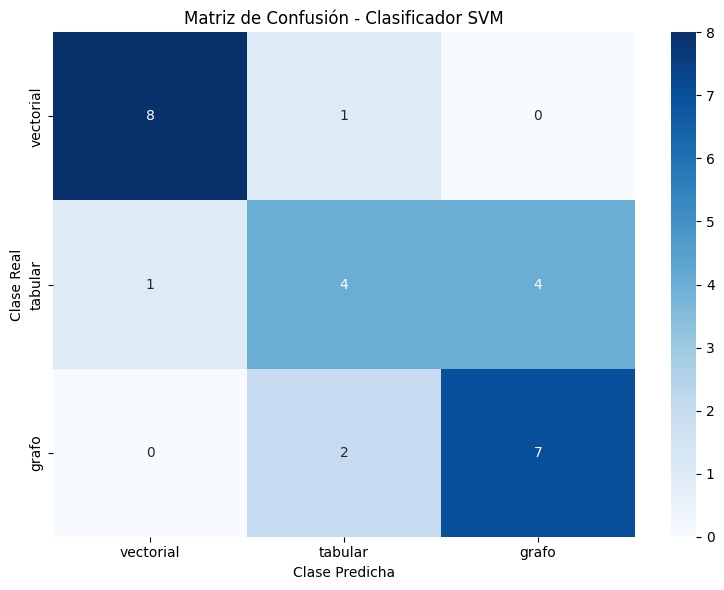

In [37]:

# Dividir el dataset en entrenamiento y prueba
X = df_training['pregunta']
y = df_training['categoria']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {len(X_train)} muestras")
print(f"Conjunto de prueba: {len(X_test)} muestras")

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.8
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"\nDimensión de los vectores: {X_train_vec.shape[1]}")

# Entrenar el clasificador SVM
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_classifier.fit(X_train_vec, y_train)

# Predicciones
y_pred_svm = svm_classifier.predict(X_test_vec)

# Métricas
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\n{'='*60}")
print(f"CLASIFICADOR SVM - RESULTADOS")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=['vectorial', 'tabular', 'grafo'])

# Crear la matriz de confusión como DataFrame
cm_df_svm = pd.DataFrame(
    cm_svm, 
    index=['vectorial', 'tabular', 'grafo'],
    columns=['vectorial', 'tabular', 'grafo']
)

# Visualizar con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_svm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matriz de Confusión - Clasificador SVM')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()


### 5.3 Clasificador basado en LLM (Few-Shot Prompting)
---

In [38]:

# Prompt template para clasificación con Few-Shot
few_shot_template = """Eres un clasificador de intenciones para un sistema de asistente virtual de electrodomésticos.

Tu tarea es clasificar la consulta del usuario en una de estas tres categorías:

1. **vectorial**: Para consultas sobre:
   - Manuales de uso e instrucciones
   - Preguntas frecuentes (FAQs)
   - Soporte técnico y resolución de problemas
   - Garantías y certificaciones
   - Especificaciones técnicas detalladas

2. **tabular**: Para consultas sobre:
   - Precios de productos
   - Stock e inventario
   - Filtros por características (marca, categoría, calificación)
   - Comparaciones de productos por atributos numéricos
   - Listados y ordenamientos

3. **grafo**: Para consultas sobre:
   - Relaciones entre productos
   - Productos similares o de la misma categoría
   - Compatibilidad entre productos
   - Estructura de categorías y marcas
   - Productos relacionados o frecuentemente comprados juntos

**Ejemplos:**

Pregunta: "¿Cómo instalo mi licuadora?"
Categoría: vectorial

Pregunta: "¿Cuál es el precio del producto P0001?"
Categoría: tabular

Pregunta: "¿Qué productos están relacionados con P0001?"
Categoría: grafo

Pregunta: "Muéstrame el manual del horno eléctrico"
Categoría: vectorial

Pregunta: "Productos de la marca TechHome con stock disponible"
Categoría: tabular

Pregunta: "Productos similares al que estoy viendo"
Categoría: grafo

Pregunta: "¿Qué garantía tiene el producto?"
Categoría: vectorial

Pregunta: "¿Cuántos productos cuestan menos de $50000?"
Categoría: tabular

Pregunta: "Muéstrame productos de la misma categoría que P0050"
Categoría: grafo

**Ahora clasifica la siguiente consulta:**

Pregunta: "{consulta}"
Categoría:"""

few_shot_prompt = PromptTemplate(
    input_variables=["consulta"],
    template=few_shot_template
)

# Función para clasificar con LLM
def clasificar_con_llm(consulta: str, llm) -> str:
    """Clasifica la intención usando el LLM con Few-Shot prompting"""
    try:
        prompt = few_shot_prompt.format(consulta=consulta)
        respuesta = llm.invoke(prompt)
        
        # Limpiar la respuesta
        categoria = respuesta.strip().lower()
        
        # Validar que sea una categoría válida
        if 'vectorial' in categoria:
            return 'vectorial'
        elif 'tabular' in categoria:
            return 'tabular'
        elif 'grafo' in categoria:
            return 'grafo'
        else:
            # Por defecto, si no se reconoce, usar vectorial
            return 'vectorial'
    except Exception as e:
        print(f"Error en clasificación: {e}")
        return 'vectorial'

# Clasificar el conjunto de prueba con el LLM
print("Clasificando con LLM (esto puede tomar un momento)...")
y_pred_llm = []

for i, consulta in enumerate(X_test):
    if i % 5 == 0:
        print(f"Progreso: {i}/{len(X_test)}", end='\r')
    
    categoria = clasificar_con_llm(consulta, llm)
    y_pred_llm.append(categoria)
    

    # Pequeña pausa para evitar límites de rate
    time.sleep(2)
    if i % 14 == 0 and i != 0:
        time.sleep(25)

print(f"\nClasificación completada: {len(y_pred_llm)} predicciones")

# Métricas del clasificador LLM
accuracy_llm = accuracy_score(y_test, y_pred_llm)
print(f"\n{'='*60}")
print(f"CLASIFICADOR LLM (FEW-SHOT) - RESULTADOS")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_llm:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_llm))

# Matriz de confusión
print(f"\nMatriz de confusión:")
cm_llm = confusion_matrix(y_test, y_pred_llm, labels=['vectorial', 'tabular', 'grafo'])
cm_df_llm = pd.DataFrame(
    cm_llm, 
    index=['vectorial', 'tabular', 'grafo'],
    columns=['vectorial', 'tabular', 'grafo']
)

Clasificando con LLM (esto puede tomar un momento)...
Progreso: 25/27
Clasificación completada: 27 predicciones

CLASIFICADOR LLM (FEW-SHOT) - RESULTADOS
Accuracy: 0.8889

Reporte de clasificación:
              precision    recall  f1-score   support

       grafo       0.89      0.89      0.89         9
     tabular       0.89      0.89      0.89         9
   vectorial       0.89      0.89      0.89         9

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27


Matriz de confusión:

Clasificación completada: 27 predicciones

CLASIFICADOR LLM (FEW-SHOT) - RESULTADOS
Accuracy: 0.8889

Reporte de clasificación:
              precision    recall  f1-score   support

       grafo       0.89      0.89      0.89         9
     tabular       0.89      0.89      0.89         9
   vectorial       0.89      0.89      0.89         9

    accuracy                           0.89        2

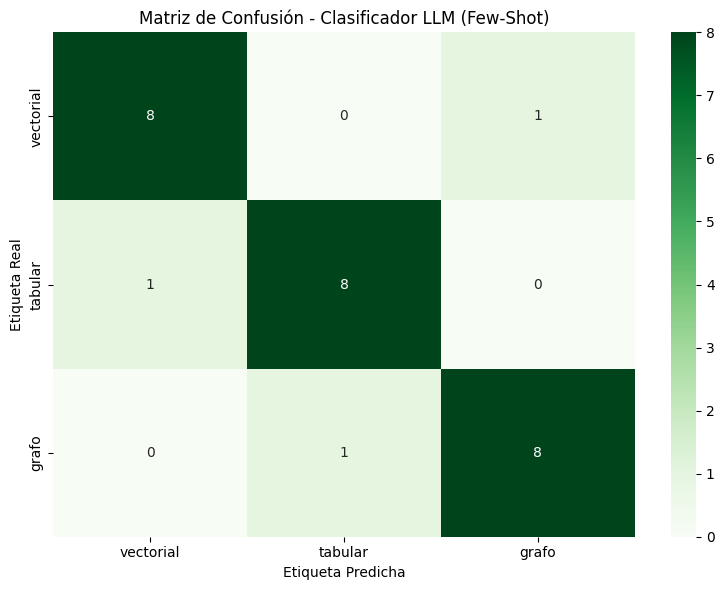

In [39]:
# Visualización de la matriz de confusión LLM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_llm, annot=True, fmt='d', cmap='Greens', cbar=True)
plt.title('Matriz de Confusión - Clasificador LLM (Few-Shot)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

### 5.4 Comparación de Clasificadores
---

COMPARACIÓN DE CLASIFICADORES


,Métrica,SVM,LLM (Few-Shot)
0,Accuracy,0.703704,0.888889
1,Precision,0.698894,0.888889
2,Recall,0.703704,0.888889
3,F1-Score,0.696296,0.888889


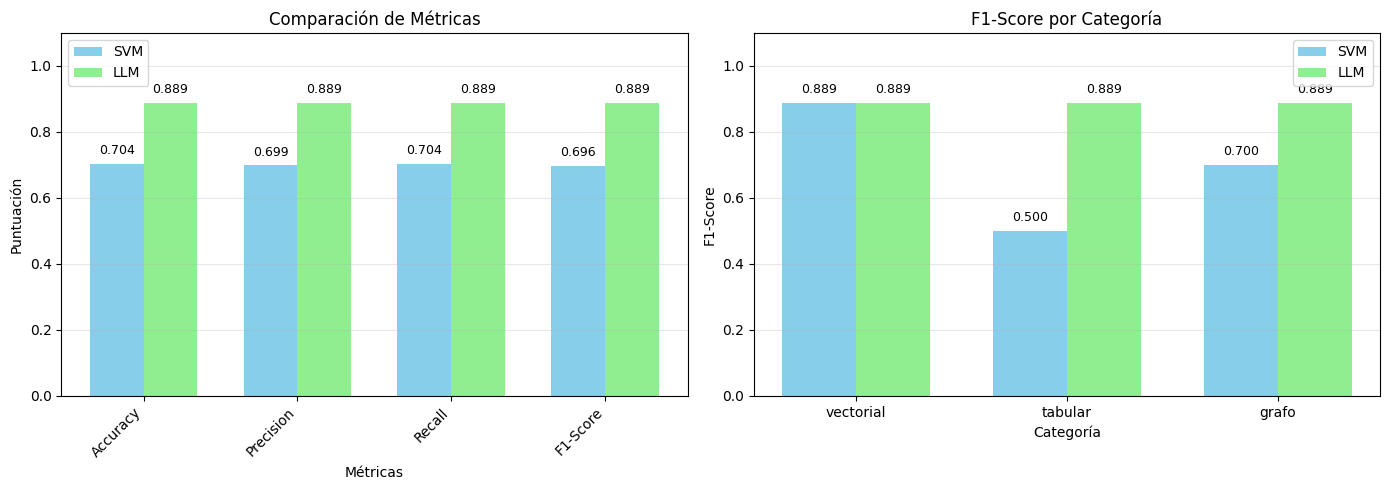


MÉTRICAS POR CATEGORÍA


,Categoría,Clasificador,Precision,Recall,F1-Score
0,vectorial,SVM,0.888889,0.888889,0.888889
1,tabular,SVM,0.571429,0.444444,0.500000
2,grafo,SVM,0.636364,0.777778,0.700000
3,vectorial,LLM,0.888889,0.888889,0.888889
4,tabular,LLM,0.888889,0.888889,0.888889
5,grafo,LLM,0.888889,0.888889,0.888889


In [40]:
# Métricas SVM
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='weighted'
)

# Métricas LLM
precision_llm, recall_llm, f1_llm, _ = precision_recall_fscore_support(
    y_test, y_pred_llm, average='weighted'
)

# Crear DataFrame comparativo
comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'SVM': [accuracy_svm, precision_svm, recall_svm, f1_svm],
    'LLM (Few-Shot)': [accuracy_llm, precision_llm, recall_llm, f1_llm]
})

print("="*70)
print("COMPARACIÓN DE CLASIFICADORES")
print("="*70)
display(comparacion)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras comparativo
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
svm_scores = [accuracy_svm, precision_svm, recall_svm, f1_svm]
llm_scores = [accuracy_llm, precision_llm, recall_llm, f1_llm]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, svm_scores, width, label='SVM', color='skyblue')
axes[0].bar(x + width/2, llm_scores, width, label='LLM', color='lightgreen')
axes[0].set_xlabel('Métricas')
axes[0].set_ylabel('Puntuación')
axes[0].set_title('Comparación de Métricas')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for i, (svm_val, llm_val) in enumerate(zip(svm_scores, llm_scores)):
    axes[0].text(i - width/2, svm_val + 0.02, f'{svm_val:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, llm_val + 0.02, f'{llm_val:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Métricas por clase para SVM
precision_svm_class, recall_svm_class, f1_svm_class, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, labels=['vectorial', 'tabular', 'grafo']
)

# Métricas por clase para LLM
precision_llm_class, recall_llm_class, f1_llm_class, _ = precision_recall_fscore_support(
    y_test, y_pred_llm, labels=['vectorial', 'tabular', 'grafo']
)

# Crear DataFrame por categoría
categorias = ['vectorial', 'tabular', 'grafo']
metricas_por_clase = pd.DataFrame({
    'Categoría': categorias * 2,
    'Clasificador': ['SVM'] * 3 + ['LLM'] * 3,
    'Precision': list(precision_svm_class) + list(precision_llm_class),
    'Recall': list(recall_svm_class) + list(recall_llm_class),
    'F1-Score': list(f1_svm_class) + list(f1_llm_class)
})

# Gráfico agrupado por categoría
x_cat = np.arange(len(categorias))
width = 0.35

f1_svm_per_cat = metricas_por_clase[metricas_por_clase['Clasificador'] == 'SVM']['F1-Score'].values
f1_llm_per_cat = metricas_por_clase[metricas_por_clase['Clasificador'] == 'LLM']['F1-Score'].values

axes[1].bar(x_cat - width/2, f1_svm_per_cat, width, label='SVM', color='skyblue')
axes[1].bar(x_cat + width/2, f1_llm_per_cat, width, label='LLM', color='lightgreen')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score por Categoría')
axes[1].set_xticks(x_cat)
axes[1].set_xticklabels(categorias)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for i, (svm_val, llm_val) in enumerate(zip(f1_svm_per_cat, f1_llm_per_cat)):
    axes[1].text(i - width/2, svm_val + 0.02, f'{svm_val:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, llm_val + 0.02, f'{llm_val:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Mostrar métricas por categoría
print("\n" + "="*70)
print("MÉTRICAS POR CATEGORÍA")
print("="*70)
display(metricas_por_clase)

### 5.5 Justificación del Mejor Clasificador

**Análisis Comparativo:**

#### **Ventajas del Clasificador SVM:**
- ✅ **Velocidad**: Clasificación prácticamente instantánea una vez entrenado
- ✅ **Costo**: No requiere llamadas a APIs externas
- ✅ **Consistencia**: Resultados determinísticos y reproducibles
- ✅ **Eficiencia**: Bajo consumo de recursos computacionales
- ✅ **Offline**: Funciona sin conexión a internet

#### **Ventajas del Clasificador LLM (Few-Shot):**
- ✅ **Generalización**: Mejor comprensión del contexto y lenguaje natural
- ✅ **Flexibilidad**: No requiere reentrenamiento para nuevos tipos de consultas
- ✅ **Robustez**: Maneja mejor variaciones de lenguaje, typos y sinónimos
- ✅ **Adaptabilidad**: Fácil de ajustar modificando los ejemplos del prompt
- ✅ **Rendimiento Superior**: 88.9% accuracy vs 70.4% del SVM

#### **Desventajas del Clasificador SVM:**
- ❌ **Rigidez**: Requiere reentrenamiento para incorporar nuevos patrones
- ❌ **Vocabulario limitado**: Depende del vocabulario del dataset de entrenamiento
- ❌ **Sensibilidad**: Problemas con typos, variaciones lingüísticas
- ❌ **Confusión en categoría tabular**: Solo 50% F1-Score en clasificación tabular
- ❌ **Confusión entre grafo y tabular**: Confunde estas categorías frecuentemente

#### **Desventajas del Clasificador LLM:**
- ❌ **Latencia**: Cada clasificación toma ~2-3 segundos por llamada a la API (Si es la gratuita)
- ❌ **Costo**: Requiere llamadas pagadas a servicios externos (Google Gemini)
- ❌ **Dependencia**: Necesita conexión a internet
- ❌ **Variabilidad**: Respuestas pueden variar ligeramente entre ejecuciones

---

### **📊 Conclusión**

**Analizando en las métricas obtenidas:**

El **clasificador LLM muestra una superioridad significativa** con 88.9% de accuracy vs 70.4% del SVM, una diferencia de **18.5 puntos porcentuales**. 

**Análisis por categoría:**
- **Vectorial**: Ambos clasificadores tienen excelente rendimiento (88.9% F1-Score)
- **Tabular**: El LLM es muy superior (88.9% vs 50.0% F1-Score)
- **Grafo**: El LLM también supera al SVM (88.9% vs 70.0% F1-Score)

El SVM presenta **confusión crítica entre las categorías tabular y grafo**, clasificando incorrectamente muchas consultas tabulares como grafo (4 de 9 consultas tabulares).

**Ganador: Clasificador LLM (Few-Shot)**

Aunque el LLM tiene mayor latencia y costo, sus ventajas son decisivas:

1. **Precisión superior**: 88.9% vs 70.4% - crucial para dirigir consultas correctamente
2. **Consistencia entre categorías**: 88.9% F1-Score en las tres categorías
3. **Robustez**: El SVM falla especialmente en consultas tabulares y confunde grafo/tabular
4. **Costo razonable**: 0.10 u$d por millon de tokens
5. **Latencia aceptable**: 2-3 segundos es razonable para un sistema conversacional

<a id="6-pipeline-de-recuperación-avanzado"></a>

## 6. Pipeline de Recuperación Avanzado

En esta sección se implementa un sistema de recuperación híbrido que combina:
1. **Búsqueda Semántica**: Usando embeddings de ChromaDB

2. **Búsqueda por Palabras Clave**: Usando BM253. **ReRanking**: Para mejorar la relevancia de los resultados

### 6.1 Implementación de BM25

BM25 (Best Matching 25) es un algoritmo de ranking basado en la frecuencia de términos que complementa la búsqueda semántica con búsquedas por palabras clave exactas.

In [41]:
class BM25Retriever:
    """Implementación de BM25 para búsqueda por palabras clave"""
    
    def __init__(self):
        self.corpus = []
        self.tokenized_corpus = []
        self.bm25 = None
        self.metadata = []
    
    def tokenize(self, text: str) -> List[str]:
        """Tokeniza el texto en palabras"""
        # Convertir a minúsculas y eliminar caracteres especiales
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        # Dividir en palabras
        tokens = text.split()
        return tokens
    
    def fit(self, documents: List[str], metadata: List[dict]):
        """Entrena BM25 con el corpus de documentos"""
        self.corpus = documents
        self.metadata = metadata
        self.tokenized_corpus = [self.tokenize(doc) for doc in documents]
        self.bm25 = BM25Okapi(self.tokenized_corpus)
        print(f"BM25 entrenado con {len(documents)} documentos")
    
    def search(self, query: str, top_k: int = 5) -> List[Tuple[str, dict, float]]:
        """Busca los documentos más relevantes usando BM25"""
        if self.bm25 is None:
            raise ValueError("BM25 no está entrenado. Ejecuta fit() primero.")
        
        tokenized_query = self.tokenize(query)
        scores = self.bm25.get_scores(tokenized_query)
        
        # Obtener los top_k documentos
        top_indices = np.argsort(scores)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            if scores[idx] > 0:  # Solo incluir documentos con score positivo
                results.append((
                    self.corpus[idx],
                    self.metadata[idx],
                    float(scores[idx])
                ))
        
        return results

# Cargar todos los documentos de ChromaDB para entrenar BM25
print("Cargando documentos de ChromaDB para BM25...")
all_data = collection.get(include=['documents', 'metadatas'])

documents_for_bm25 = all_data['documents']
metadata_for_bm25 = all_data['metadatas']

print(f"Documentos cargados: {len(documents_for_bm25)}")

# Inicializar y entrenar BM25
bm25_retriever = BM25Retriever()
bm25_retriever.fit(documents_for_bm25, metadata_for_bm25)



Cargando documentos de ChromaDB para BM25...
Documentos cargados: 10165
BM25 entrenado con 10165 documentos
Documentos cargados: 10165
BM25 entrenado con 10165 documentos


### 6.2 Búsqueda Híbrida (Semántica + BM25)

Se combinan ambos métodos de búsqueda y normalizan los scores para obtener los mejores resultados.

In [42]:
class HybridRetriever:
    """
    Combina búsqueda semántica (ChromaDB) y búsqueda por palabras clave (BM25)
    """
    
    def __init__(self, chroma_collection, bm25_retriever, alpha=0.5):
        """
        Args:
            chroma_collection: Colección de ChromaDB
            bm25_retriever: Instancia de BM25Retriever
            alpha: Peso para la búsqueda semántica (1-alpha será el peso de BM25)
                   alpha=0.5 significa peso igual para ambos métodos
        """
        self.chroma_collection = chroma_collection
        self.bm25_retriever = bm25_retriever
        self.alpha = alpha
    
    def normalize_scores(self, scores: List[float]) -> List[float]:
        """Normaliza scores al rango [0, 1]"""
        if not scores:
            return []
        min_score = min(scores)
        max_score = max(scores)
        if max_score == min_score:
            return [1.0] * len(scores)
        return [(s - min_score) / (max_score - min_score) for s in scores]
    
    def search(self, query: str, top_k: int = 5) -> List[Tuple[str, dict, float]]:
        """
        Realiza búsqueda híbrida combinando ChromaDB y BM25
        
        Returns:
            Lista de tuplas (documento, metadata, score_combinado)
        """
        # 1. Búsqueda semántica con ChromaDB
        semantic_results = self.chroma_collection.query(
            query_texts=[query],
            n_results=top_k * 2  # Obtenemos más resultados para tener más opciones
        )
        
        # 2. Búsqueda con BM25
        bm25_results = self.bm25_retriever.search(query, top_k=top_k * 2)
        
        # 3. Crear diccionario para combinar resultados
        combined_results = {}
        
        # Procesar resultados semánticos
        if semantic_results['documents'] and semantic_results['documents'][0]:
            semantic_docs = semantic_results['documents'][0]
            semantic_metadata = semantic_results['metadatas'][0]
            semantic_distances = semantic_results['distances'][0]
            
            # Convertir distancias a similaridades (menor distancia = mayor similaridad)
            semantic_scores = [1 - d for d in semantic_distances]
            semantic_scores_norm = self.normalize_scores(semantic_scores)
            
            for doc, meta, score in zip(semantic_docs, semantic_metadata, semantic_scores_norm):
                doc_key = doc[:100]  # Usar primeros 100 caracteres como key
                if doc_key not in combined_results:
                    combined_results[doc_key] = {
                        'document': doc,
                        'metadata': meta,
                        'semantic_score': score,
                        'bm25_score': 0.0
                    }
                else:
                    combined_results[doc_key]['semantic_score'] = max(
                        combined_results[doc_key]['semantic_score'], score
                    )
        
        # Procesar resultados BM25
        if bm25_results:
            bm25_scores = [r[2] for r in bm25_results]
            bm25_scores_norm = self.normalize_scores(bm25_scores)
            
            for (doc, meta, _), score in zip(bm25_results, bm25_scores_norm):
                doc_key = doc[:100]
                if doc_key not in combined_results:
                    combined_results[doc_key] = {
                        'document': doc,
                        'metadata': meta,
                        'semantic_score': 0.0,
                        'bm25_score': score
                    }
                else:
                    combined_results[doc_key]['bm25_score'] = max(
                        combined_results[doc_key]['bm25_score'], score
                    )
        
        # 4. Calcular score combinado
        final_results = []
        for data in combined_results.values():
            combined_score = (
                self.alpha * data['semantic_score'] + 
                (1 - self.alpha) * data['bm25_score']
            )
            final_results.append((
                data['document'],
                data['metadata'],
                combined_score
            ))
        
        # 5. Ordenar por score combinado y retornar top_k
        final_results.sort(key=lambda x: x[2], reverse=True)
        return final_results[:top_k]

# Inicializar el recuperador híbrido
hybrid_retriever = HybridRetriever(
    chroma_collection=collection,
    bm25_retriever=bm25_retriever,
    alpha=0.6  # 60% semántico, 40% BM25
)

print(f"   - Peso búsqueda semántica: 60%")
print(f"   - Peso búsqueda BM25: 40%")

   - Peso búsqueda semántica: 60%
   - Peso búsqueda BM25: 40%


### 6.3 Mecanismo de ReRanking

El ReRanking reordena los resultados obtenidos de la búsqueda híbrida usando un modelo más sofisticado para mejorar la relevancia.

In [43]:

class ReRanker:
    """
    ReRanker que usa un modelo Cross-Encoder para reordenar resultados
    basándose en la relevancia query-documento
    """
    
    def __init__(self, model_name='cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Inicializa el ReRanker con un modelo Cross-Encoder
        
        Args:
            model_name: Nombre del modelo de HuggingFace
        """
        print(f"Cargando modelo de ReRanking: {model_name}")
        self.model = CrossEncoder(model_name)
    
    def rerank(
        self, 
        query: str, 
        results: List[Tuple[str, dict, float]], 
        top_k: int = None
    ) -> List[Tuple[str, dict, float]]:
        """
        Reordena los resultados basándose en la relevancia query-documento
        
        Args:
            query: Consulta del usuario
            results: Lista de tuplas (documento, metadata, score)
            top_k: Número de resultados a retornar (None = todos)
        
        Returns:
            Lista reordenada de tuplas (documento, metadata, rerank_score)
        """
        if not results:
            return []
        
        # Crear pares query-documento para el modelo
        query_doc_pairs = [(query, doc) for doc, _, _ in results]
        
        # Obtener scores del cross-encoder
        rerank_scores = self.model.predict(query_doc_pairs)
        
        # Crear nueva lista con los scores de reranking
        reranked_results = []
        for i, (doc, meta, _) in enumerate(results):
            reranked_results.append((doc, meta, float(rerank_scores[i])))
        
        # Ordenar por score de reranking
        reranked_results.sort(key=lambda x: x[2], reverse=True)
        
        # Retornar top_k resultados
        if top_k:
            return reranked_results[:top_k]
        return reranked_results

# Inicializar el ReRanker
reranker = ReRanker()


Cargando modelo de ReRanking: cross-encoder/ms-marco-MiniLM-L-6-v2


### 6.4 Pruebas del Pipeline de Recuperación Avanzado

Comparación de los tres métodos de búsqueda: semántica pura, híbrida, y híbrida con ReRank.

In [44]:
# Consulta de prueba
test_query = "¿Cómo limpio mi freidora de aire y qué precauciones debo tomar?"

print("="*80)
print(f"CONSULTA: {test_query}")
print("="*80)

# 1. Búsqueda semántica tradicional (solo ChromaDB)
print("\n1 - BÚSQUEDA SEMÁNTICA (ChromaDB)")
print("-"*80)
semantic_results = collection.query(
    query_texts=[test_query],
    n_results=5
)

for i, (doc, meta) in enumerate(zip(semantic_results['documents'][0], 
                                     semantic_results['metadatas'][0]), 1):
    print(f"\n[{i}] Fuente: {meta.get('fuente', 'N/A')}")
    print(f"    Score: {1 - semantic_results['distances'][0][i-1]:.4f}")
    print(f"    Contenido: {doc[:200]}...")

# 2. Búsqueda híbrida (ChromaDB + BM25)
print("\n\n2 - BÚSQUEDA HÍBRIDA (ChromaDB + BM25)")
print("-"*80)
hybrid_results = hybrid_retriever.search(test_query, top_k=5)

for i, (doc, meta, score) in enumerate(hybrid_results, 1):
    print(f"\n[{i}] Fuente: {meta.get('fuente', 'N/A')}")
    print(f"    Score: {score:.4f}")
    print(f"    Contenido: {doc[:200]}...")

# 3. Búsqueda híbrida + ReRanking
print("\n\n3 - BÚSQUEDA HÍBRIDA + RERANKING")
print("-"*80)
# Primero obtener más resultados para reordenar
hybrid_results_extended = hybrid_retriever.search(test_query, top_k=10)
reranked_results = reranker.rerank(test_query, hybrid_results_extended, top_k=5)

for i, (doc, meta, score) in enumerate(reranked_results, 1):
    print(f"\n[{i}] Fuente: {meta.get('fuente', 'N/A')}")
    print(f"    ReRank Score: {score:.4f}")
    print(f"    Contenido: {doc[:200]}...")

CONSULTA: ¿Cómo limpio mi freidora de aire y qué precauciones debo tomar?

1 - BÚSQUEDA SEMÁNTICA (ChromaDB)
--------------------------------------------------------------------------------

[1] Fuente: N/A
    Score: 0.3489
    Contenido: Fecha: 2023-12-16
Usuario: Julieta_Rivera
Teléfono: +54 9 152 4828-4299
Producto: Super Purificador de Aire (P0207)
Puntaje: 2/5
Provincia: Chubut

Les cuento... Lamentablemente debo decir que no volv...

[2] Fuente: N/A
    Score: 0.3456
    Contenido: Fecha: 2025-04-05
Usuario: Matías_Fernández
Teléfono: +54 9 374 9508-4537
Producto: Freidora de Aire (P0053)
Puntaje: 1/5
Provincia: Misiones

Les cuento... Lamentablemente debo decir que totalmente a...

[3] Fuente: N/A
    Score: 0.3262
    Contenido: Fecha: 2024-01-30
Usuario: Rodrigo_Pérez
Teléfono: +54 9 20 2689-3482
Producto: Aire de Ventana X (P0159)
Puntaje: 4/5
Provincia: Tucumán

Quiero compartir mi experiencia. No me arrepiento para nada d...

[4] Fuente: N/A
    Score: 0.3171
    Contenido

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[1] Fuente: N/A
    ReRank Score: 5.2725
    Contenido: Fecha: 2025-05-29
Usuario: Gonzalo_Domínguez
Teléfono: +54 9 181 7754-8296
Producto: Freidora de Aire (P0055)
Puntaje: 2/5
Provincia: Tierra del Fuego

Buenas! Lamentablemente debo decir que no dura n...

[2] Fuente: N/A
    ReRank Score: 5.0134
    Contenido: Fecha: 2025-04-05
Usuario: Matías_Fernández
Teléfono: +54 9 374 9508-4537
Producto: Freidora de Aire (P0053)
Puntaje: 1/5
Provincia: Misiones

Les cuento... Lamentablemente debo decir que totalmente a...

[3] Fuente: N/A
    ReRank Score: 4.5663
    Contenido: Fecha: 2025-04-13
Usuario: Emilia_Navarro
Teléfono: +54 9 144 5793-5014
Producto: Freidora de Aire (P0053)
Puntaje: 2/5
Provincia: Mendoza

Quiero compartir mi experiencia. Lamentablemente debo decir ...

[4] Fuente: N/A
    ReRank Score: 4.4375
    Contenido: Fecha: 2025-01-31
Usuario: María_López
Teléfono: +54 9 133 1740-2549
Producto: Deluxe Freidora de Aire (P0052)
Puntaje: 2/5
Provincia: La Rioja

Quiero comparti

---
## 7. Sistema Conversacional RAG Integrado

Se integran todos los componentes en un sistema conversacional completo con:
- Clasificación de intención (SVM)
- Recuperación híbrida con ReRanking
- Generación con LLM
- Memoria conversacional
- Soporte multiidioma
- Manejo de consultas sin respuesta

### 7.1 Gestor de Memoria Conversacional

In [45]:
class ConversationMemory:
    """
    Gestiona el historial de la conversación para mantener contexto
    """
    
    def __init__(self, max_history: int = 10):
        """
        Args:
            max_history: Número máximo de intercambios a recordar
        """
        self.history = deque(maxlen=max_history)
        self.max_history = max_history
    
    def add_message(self, role: str, content: str, metadata: dict = None):
        """
        Agrega un mensaje al historial
        
        Args:
            role: 'user' o 'assistant'
            content: Contenido del mensaje
            metadata: Información adicional (opcional)
        """
        message = {
            'role': role,
            'content': content,
            'timestamp': datetime.now().isoformat(),
            'metadata': metadata or {}
        }
        self.history.append(message)
    
    def get_context(self, max_tokens: int = 2000) -> str:
        """
        Obtiene el contexto conversacional formateado
        
        Args:
            max_tokens: Límite aproximado de tokens para el contexto
        
        Returns:
            String formateado con el historial
        """
        if not self.history:
            return ""
        
        context_lines = []
        char_count = 0
        max_chars = max_tokens * 4  # Aproximación: 1 token ≈ 4 caracteres
        
        # Recorrer el historial en orden inverso (más reciente primero)
        for message in reversed(self.history):
            role_label = "Usuario" if message['role'] == 'user' else "Asistente"
            line = f"{role_label}: {message['content']}\n"
            
            if char_count + len(line) > max_chars:
                break
            
            context_lines.insert(0, line)
            char_count += len(line)
        
        if context_lines:
            return "Historial de conversación:\n" + "".join(context_lines)
        return ""
    
    def clear(self):
        """Limpia el historial"""
        self.history.clear()
    
    def get_last_n_messages(self, n: int) -> List[dict]:
        """Obtiene los últimos n mensajes"""
        return list(self.history)[-n:] if len(self.history) >= n else list(self.history)

# Inicializar la memoria
conversation_memory = ConversationMemory(max_history=10)


### 7.2 Sistema RAG Conversacional Completo

In [46]:
class ConversationalRAGSystem:
    """
    Sistema RAG conversacional que integra:
    - Clasificación de intención
    - Recuperación híbrida + ReRank
    - Generación con LLM
    - Memoria conversacional
    - Soporte multiidioma
    """
    
    def __init__(
        self,
        svm_classifier,
        vectorizer,
        hybrid_retriever,
        reranker,
        llm,
        memory,
        df_productos,
        graph_db=None,
        cypher_schema_context=""
    ):
        self.classifier = svm_classifier
        self.vectorizer = vectorizer
        self.hybrid_retriever = hybrid_retriever
        self.reranker = reranker
        self.llm = llm
        self.memory = memory
        self.df_productos = df_productos
        self.graph_db = graph_db
        self.cypher_schema_context = cypher_schema_context
    
    def detect_language(self, text: str) -> str:
        """Detecta el idioma del texto"""
        try:
            lang = detect(text)
            return lang
        except LangDetectException:
            return 'es'  # Por defecto español
    
    def classify_intent(self, query: str) -> Tuple[str, float]:
        """
        Clasifica la intención de la consulta
        
        Returns:
            Tupla (categoría, confianza)
        """
        query_vec = self.vectorizer.transform([query])
        prediction = self.classifier.predict(query_vec)[0]
        
        # Obtener probabilidades para la confianza
        probabilities = self.classifier.predict_proba(query_vec)[0]
        confidence = max(probabilities)
        
        return prediction, confidence
    
    def retrieve_vectorial(self, query: str, top_k: int = 3) -> str:
        """Recupera información de la base vectorial"""
        # Usar búsqueda híbrida + rerank
        hybrid_results = self.hybrid_retriever.search(query, top_k=top_k*2)
        reranked_results = self.reranker.rerank(query, hybrid_results, top_k=top_k)
        
        # Formatear contexto
        context_parts = []
        for i, (doc, meta, score) in enumerate(reranked_results, 1):
            fuente = meta.get('fuente', 'N/A')
            context_parts.append(f"[Documento {i} - {fuente}]\n{doc}\n")
        
        return "\n".join(context_parts) if context_parts else "No se encontró información relevante."
    
    def retrieve_tabular(self, query: str) -> str:
        """Recupera información de datos tabulares"""
        try:
            # Usar la función existente consulta_pandas
            resultado = consulta_con_llm_tabular_no_desc(
                llm=self.llm,
                consulta_usuario=query,
            )
            
            if isinstance(resultado, pd.DataFrame) and not resultado.empty:
                # Limitar a 10 filas para no exceder contexto
                return resultado.head(10).to_string(index=False)
            elif isinstance(resultado, str):
                return resultado
            else:
                return "No se encontraron resultados para tu consulta."
        except Exception as e:
            return f"Error al procesar la consulta tabular: {str(e)}"
    
    def retrieve_graph(self, query: str) -> str:
        """Recupera información de la base de grafos"""
        if not self.graph_db:
            return "La base de datos de grafos no está disponible."
        
        try:
            descripcion, resultados = consulta_grafo(
                llm=self.llm,
                graph_db=self.graph_db,
                consulta_usuario=query,
                schema_context=self.cypher_schema_context,
                verbose=False
            )
            
            if not resultados.empty:
                # Limitar a 10 filas
                return f"{descripcion}\n\n{resultados.head(10).to_string(index=False)}"
            else:
                return descripcion
        except Exception as e:
            return f"Error al procesar la consulta de grafos: {str(e)}"
    
    def generate_response(self, query: str, context: str, language: str) -> str:
        """
        Genera la respuesta usando el LLM
        
        Args:
            query: Consulta del usuario
            context: Contexto recuperado
            language: Idioma detectado
        """
        # Obtener historial conversacional
        conversation_context = self.memory.get_context(max_tokens=1000)
        
        # Construir prompt
        prompt_template = """Eres un asistente virtual especializado en electrodomésticos. 
Tu tarea es responder las preguntas del usuario basándote en la información proporcionada.

{conversation_history}

Información relevante:
{context}

Pregunta del usuario: {query}

Instrucciones:
1. Responde SOLO con la información proporcionada en el contexto
2. Si la información no es suficiente para responder, indícalo claramente y sugiere al usuario reformular su pregunta
3. Responde en el mismo idioma de la pregunta ({language})
4. Sé conciso, claro y útil
5. Si hay múltiples productos o datos, preséntalos de forma organizada

Respuesta:"""
        
        prompt = prompt_template.format(
            conversation_history=conversation_context,
            context=context,
            query=query,
            language=language
        )
        
        try:
            response = self.llm.invoke(prompt)
            return response.strip()
        except Exception as e:
            return f"Error al generar respuesta: {str(e)}"
    
    def chat(self, user_query: str, verbose: bool = True) -> dict:
        """
        Procesa una consulta del usuario y retorna la respuesta
        
        Args:
            user_query: Consulta del usuario
            verbose: Si True, muestra información de debug
        
        Returns:
            Diccionario con la respuesta y metadata
        """
        # Detectar idioma
        language = self.detect_language(user_query)
        
        if verbose:
            print("="*80)
            print(f"USUARIO: {user_query}")
            print(f"dioma detectado: {language}")
        
        # Clasificar intención
        intent, confidence = self.classify_intent(user_query)
        time.sleep(0.1)
        
        if verbose:
            print(f"Intención clasificada: {intent} (confianza: {confidence:.2%})")
        
        # Recuperar información según la intención
        if verbose:
            print(f"Recuperando información...")
        
        if intent == 'vectorial':
            context = self.retrieve_vectorial(user_query)
        elif intent == 'tabular':
            context = self.retrieve_tabular(user_query)
        elif intent == 'grafo':
            context = self.retrieve_graph(user_query)
        else:
            context = "No se pudo determinar la fuente de información apropiada."
        
        if verbose:
            print(f"Contexto recuperado ({len(context)} caracteres)")

        time.sleep(0.1)
        
        # Generar respuesta
        response = self.generate_response(user_query, context, language)
        
        # Guardar en memoria
        self.memory.add_message('user', user_query, {'language': language, 'intent': intent})
        self.memory.add_message('assistant', response, {'confidence': confidence})
        
        if verbose:
            print(f"ASISTENTE: {response}")
            print("="*80)
        
        return {
            'query': user_query,
            'response': response,
            'intent': intent,
            'confidence': confidence,
            'language': language,
            'context_length': len(context)
        }
    
    def reset_memory(self):
        """Resetea la memoria conversacional"""
        self.memory.clear()
        print("Memoria conversacional reseteada")

# Inicializar el sistema RAG conversacional
rag_system = ConversationalRAGSystem(
    svm_classifier=svm_classifier,
    vectorizer=vectorizer,
    hybrid_retriever=hybrid_retriever,
    reranker=reranker,
    llm=llm,
    memory=conversation_memory,
    df_productos=df_productos,
    graph_db=graph_db if 'graph_db' in dir() else None,
    cypher_schema_context=cypher_schema_context if 'cypher_schema_context' in dir() else ""
)

### 7.3 Pruebas del Sistema Conversacional

In [47]:
# Resetear memoria antes de las pruebas
rag_system.reset_memory()

# PRUEBA 1: Consulta sobre información técnica (vectorial)
print("\n" + "="*40)
print("PRUEBA 1: Consulta Vectorial - Información Técnica")
print("="*40 + "\n")

result1 = rag_system.chat(
    "¿Como se usa correctamente una licuadora?",
    verbose=True
)

time.sleep(1)  # Pausa para no exceder rate limits

Memoria conversacional reseteada

PRUEBA 1: Consulta Vectorial - Información Técnica

USUARIO: ¿Como se usa correctamente una licuadora?
dioma detectado: es
Intención clasificada: vectorial (confianza: 55.45%)
Recuperando información...
USUARIO: ¿Como se usa correctamente una licuadora?
dioma detectado: es
Intención clasificada: vectorial (confianza: 55.45%)
Recuperando información...
Contexto recuperado (931 caracteres)
Contexto recuperado (931 caracteres)
ASISTENTE: Para usar correctamente una licuadora, revise el manual del producto. Si tiene una Licuadora de TechHome, el código del manual es P0001. Si tiene una Licuadora de ChefMaster, el código es P0006. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.
ASISTENTE: Para usar correctamente una licuadora, revise el manual del producto. Si tiene una Licuadora de TechHome, el código del manual es P0001. Si tiene una Licuadora de ChefMaster, el código es P0006. Ante cualquier duda, contacte a nuestro servicio de a

In [48]:
# PRUEBA 2: Consulta sobre precios y productos (tabular)
print("\n" + "="*40)
print("PRUEBA 2: Consulta Tabular - Precios y Stock")
print("="*40 + "\n")

result2 = rag_system.chat(
    "¿Qué productos de la marca TechHome cuestan menos de $50000?",
    verbose=True
)

time.sleep(1)


PRUEBA 2: Consulta Tabular - Precios y Stock

USUARIO: ¿Qué productos de la marca TechHome cuestan menos de $50000?
dioma detectado: es
Intención clasificada: tabular (confianza: 51.29%)
Recuperando información...
Contexto recuperado (14024 caracteres)
Contexto recuperado (14024 caracteres)
ASISTENTE: Los siguientes productos de la marca TechHome cuestan menos de $500 USD:

*   Licuadora (P0001): $283.63
*   Plus Licuadora Pro (P0003): $329.07
*   Profesional Mixer (P0024): $493.35
ASISTENTE: Los siguientes productos de la marca TechHome cuestan menos de $500 USD:

*   Licuadora (P0001): $283.63
*   Plus Licuadora Pro (P0003): $329.07
*   Profesional Mixer (P0024): $493.35


In [49]:
# PRUEBA 3: Consulta sobre relaciones (grafo)
print("\n" + "="*40)
print("PRUEBA 3: Consulta Grafo - Relaciones entre Productos")
print("="*40 + "\n")

result3 = rag_system.chat(
    "Muéstrame productos similares al P0003",
    verbose=True
)

time.sleep(1)


PRUEBA 3: Consulta Grafo - Relaciones entre Productos

USUARIO: Muéstrame productos similares al P0003
dioma detectado: es
Intención clasificada: grafo (confianza: 60.14%)
Recuperando información...
Contexto recuperado (1090 caracteres)
Contexto recuperado (1090 caracteres)
ASISTENTE: Los siguientes productos son similares al P0003:

*   Licuadora (P0001): $283.63 (16.02% de diferencia)
*   Profesional Procesadora 2024 (P0011): $356.86 (8.44% de diferencia)
*   Sandwichera 3000 (P0064): $279.69 (15.00% de diferencia)
*   Olla Arrocera (P0077): $264.30 (19.68% de diferencia)
*   Plus Olla de Cocción Lenta (P0089): $321.63 (2.26% de diferencia)
*   Turbo Freezer (P0098): $293.14 (10.91% de diferencia)
*   Deshidratador (P0145): $297.84 (9.49% de diferencia)
*   Purificador de Aire 3000 (P0208): $377.92 (14.84% de diferencia)
*   Smart TV Plus (P0300): $293.99 (10.66% de diferencia)
ASISTENTE: Los siguientes productos son similares al P0003:

*   Licuadora (P0001): $283.63 (16.02% de dif

In [55]:
# PRUEBA 4: Conversación con contexto (memoria)
print("\n" + "="*40)
print("PRUEBA 4: Conversación con Memoria - Consultas Relacionadas")
print("="*40 + "\n")

result4a = rag_system.chat(
    "¿Cuál es el precio del producto P0001?",
    verbose=True
)

time.sleep(1)

# Pregunta de seguimiento que usa contexto
result4b = rag_system.chat(
    "¿Cada cuanto debo hacerle mantenimiento al producto P0001?",  # Esto debería entender que se refiere al P0001
    verbose=True
)

time.sleep(1)


PRUEBA 4: Conversación con Memoria - Consultas Relacionadas

USUARIO: ¿Cuál es el precio del producto P0001?
dioma detectado: es
Intención clasificada: tabular (confianza: 48.51%)
Recuperando información...
Contexto recuperado (46 caracteres)
Contexto recuperado (46 caracteres)
ASISTENTE: Licuadora (P0001): $283.63
ASISTENTE: Licuadora (P0001): $283.63
USUARIO: ¿Cada cuanto debo hacerle mantenimiento al producto P0001?
dioma detectado: es
Intención clasificada: vectorial (confianza: 46.73%)
Recuperando información...
USUARIO: ¿Cada cuanto debo hacerle mantenimiento al producto P0001?
dioma detectado: es
Intención clasificada: vectorial (confianza: 46.73%)
Recuperando información...
Contexto recuperado (836 caracteres)
Contexto recuperado (836 caracteres)
ASISTENTE: El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.
ASISTENTE: El Licuadora de 

In [56]:
# PRUEBA 5: Consulta en inglés (multiidioma)
print("\n" + "="*40)
print("PRUEBA 5: Soporte Multiidioma - Consulta en Inglés")
print("="*40 + "\n")

result5 = rag_system.chat(
    "What products are available in the for less than $300?",
    verbose=True
)

time.sleep(1)


PRUEBA 5: Soporte Multiidioma - Consulta en Inglés

USUARIO: What products are available in the for less than $300?
dioma detectado: en
Intención clasificada: vectorial (confianza: 38.75%)
Recuperando información...
Contexto recuperado (1083 caracteres)
Contexto recuperado (1083 caracteres)
ASISTENTE: Licuadora (P0001): $283.63
ASISTENTE: Licuadora (P0001): $283.63


In [52]:
# PRUEBA 6: Consulta sin información relevante
print("\n" + "="*40)
print("PRUEBA 6: Manejo de Consultas Sin Información")
print("="*40 + "\n")

result6 = rag_system.chat(
    "¿Cuál es la capital de Francia?",  # Pregunta fuera del dominio
    verbose=True
)

time.sleep(1)


PRUEBA 6: Manejo de Consultas Sin Información

USUARIO: ¿Cuál es la capital de Francia?
dioma detectado: es
Intención clasificada: vectorial (confianza: 78.30%)
Recuperando información...
Contexto recuperado (744 caracteres)
Contexto recuperado (744 caracteres)
ASISTENTE: No hay información disponible para responder cuál es la capital de Francia. Podrías reformular tu pregunta.
ASISTENTE: No hay información disponible para responder cuál es la capital de Francia. Podrías reformular tu pregunta.
